In [1]:
#Author: Robert Mesías Pérez Ramón
#Program: Master universitario Inteligencia Artificial
#Subject: Modelo de Clasificación de Nodulos tiroideos en imágenes de ultrasonido usando Deep Learning según sistema TIRADS
#Date: Jun 25
#University: Universidad Alfonso X El Sabio
#Tutor: Angel Rayo Acevedo

# **I. Importación de Librerías**

In [2]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import re
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.applications import InceptionV3, VGG16, VGG19, ResNet50, Xception

# **II. Carga y Review de Dataset (Imágenes)**

Procederemos a cargar los archivos de las imágenes obtenidas de ultrasonido de Tiroides, basándose en la categorización de EU-TIRADS

**A. Definimos el directorio donde se encuentran lás imágenes**

In [9]:
directory = 'D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/data/EuTiradsData'   

In [10]:
 print(directory)

D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/data/EuTiradsData


**B. Tratamiento de imágenes a nivel de directorios y dataframe**

* Recorremos todas las imágenes y mapeamos la lista obtenida en un dataframe

In [11]:
#Iniciaizamos listas para almacenar los datos
image_data = []
invalid_images = []

In [12]:
#Se definen las clases TI-RADS
classes = ['TIRADS1', 'TIRADS2', 'TIRADS3', 'TIRADS4', 'TIRADS5']

In [13]:
#Recorremos las carpetas de clases (TIRADS1, TIRADS2, etc.)
for class_name in classes:
    class_folder = os.path.join(directory, class_name)  # Ruta de la clase (TIRADS1, TIRADS2, etc.)
    
    #Obtenemos todas las imágenes en la carpeta
    for image_file in os.listdir(class_folder):
        if image_file.endswith('.jpg') or image_file.endswith('.png') or image_file.endswith('.jpeg'): #Formato de imágenes
            image_path = os.path.join(class_folder, image_file)
            image_name = os.path.basename(image_path)
            
            #Luego agregamos la ruta de la imagen, la etiqueta TI-RADS y el nombre de la imagen al diccionario
            image_data.append({
                'Full_Path': image_path,
                'Tirads': int(class_name[-1]),  # La etiqueta TI-RADS es el último número de la carpeta (1, 2, 3, 4, 5)
                'Image_Name': image_name
            })

In [14]:
#Convertimos la lista de datos a un DataFrame
images_df = pd.DataFrame(image_data)

In [15]:
images_df

,Full_Path,Tirads,Image_Name
0,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides1.jpg
1,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides10.jpg
2,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides100.jpg
3,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides1000.jpg
4,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides1001.jpg
...,...,...,...
5297,D:/Academico/Master Inteligencia Artificial - ...,5,tiroides95.jpg
5298,D:/Academico/Master Inteligencia Artificial - ...,5,tiroides96.jpg
5299,D:/Academico/Master Inteligencia Artificial - ...,5,tiroides97.jpg
5300,D:/Academico/Master Inteligencia Artificial - ...,5,tiroides98.jpg


* Agregamos un campo referente al dimensión de la imagen (Ancho, Alto)

In [16]:
#Definimos una función para obtener el tamaño de las imágenes
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size  # Devuelve las dimensiones de la imagen
    except Exception as e:
        print(f"Error al abrir la imagen {image_path}: {e}")
        invalid_images.append(image_path)  # Guardamos aquí la imagen no válida
        return None  # Si no se puede abrir la imagen, retornar None

In [17]:
#Agregamos las dimensiones de cada imagen al DataFrame
images_df['Image_Size'] = images_df['Full_Path'].apply(get_image_size)

Error al abrir la imagen D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/data/EuTiradsData\TIRADS5\tiroides590.jpg: cannot identify image file 'D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/data/EuTiradsData\\TIRADS5\\tiroides590.jpg'


In [18]:
images_df.head(5)

,Full_Path,Tirads,Image_Name,Image_Size
0,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides1.jpg,"(289, 254)"
1,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides10.jpg,"(276, 272)"
2,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides100.jpg,"(378, 159)"
3,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides1000.jpg,"(268, 157)"
4,D:/Academico/Master Inteligencia Artificial - ...,1,tiroides1001.jpg,"(199, 231)"


In [19]:
images_df.shape

(5302, 4)

In [15]:
invalid_images

['D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/data/EuTiradsData\\TIRADS5\\tiroides590.jpg']

**C. Visualización de las imágenes cargadas, de acuerdo al dataframe creado**

In [15]:
# Función para visualizar imágenes filtradas por TI-RADS y Número de Imagen
def display_images_with_info(images_df, tirads_label=None, image_id=None):
    # Filtrar por TI-RADS
    if tirads_label:
        filtered_df = images_df[images_df['Tirads'] == tirads_label]
    else:
        filtered_df = images_df  # Si no se pasa un TI-RADS, mostrar todas las imágenes
    
    # Filtrar por número de imagen (usando comparación exacta)
    if image_id:
        # Filtrar imágenes cuyo nombre sea exactamente 'tiroidesX.jpg' donde X es el número de la imagen
        filtered_df = filtered_df[filtered_df['Image_Name'] == f"tiroides{image_id}.jpg"]
    
    # Verificar si se han encontrado imágenes
    num_images = len(filtered_df)
    
    if num_images > 0:
        print(f"Se encontraron {num_images} imágenes para TI-RADS {tirads_label} y número de imagen {image_id}:")
        for _, row in filtered_df.iterrows():
            try:
                jpg_path = row['Full_Path']
                img = Image.open(jpg_path)
                
                # Mostrar la imagen usando matplotlib
                plt.imshow(img)
                plt.axis('off')  # Desactivar los ejes
                plt.show()  # Mostrar la imagen
                
                print(f"Imagen: {jpg_path}")
                print(f"Tirads: {row['Tirads']}, Image Name: {row['Image_Name']}, Image Size: {row['Image_Size']}")

            except Exception as e:
                print(f"Error al abrir la imagen {jpg_path}: {e}")
    else:
        print(f"No se encontraron imágenes para TI-RADS {tirads_label} y número de imagen {image_id}")

Se encontraron 1 imágenes para TI-RADS 5 y número de imagen 13:


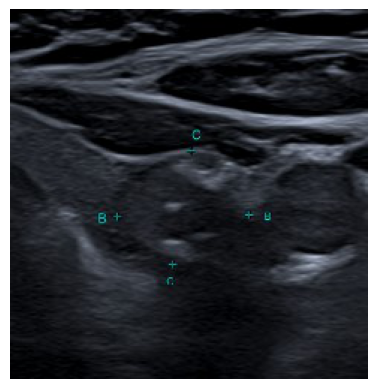

Imagen: D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/data/EuTiradsData\TIRADS5\tiroides13.jpg
Tirads: 5, Image Name: tiroides13.jpg, Image Size: (239, 247)


In [16]:
# Ejemplo de uso: Filtrar por TI-RADS = '1' y número de imagen = 1
display_images_with_info(images_df, tirads_label=5, image_id=13)

# **III. Análisis Exploratorio de Datos (EDA)**

**A. Distribución de Clases Tirads**

* Primero realizamos un overview de las imágenes obtenidas

In [20]:
print(images_df.shape)

(5302, 4)


In [21]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5302 entries, 0 to 5301
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Full_Path   5302 non-null   object
 1   Tirads      5302 non-null   int64 
 2   Image_Name  5302 non-null   object
 3   Image_Size  5301 non-null   object
dtypes: int64(1), object(3)
memory usage: 165.8+ KB


In [22]:
tirads_counts = images_df['Tirads'].value_counts().sort_index(ascending=True)
print(tirads_counts)

Tirads
1    1835
2    1074
3     703
4     753
5     937
Name: count, dtype: int64


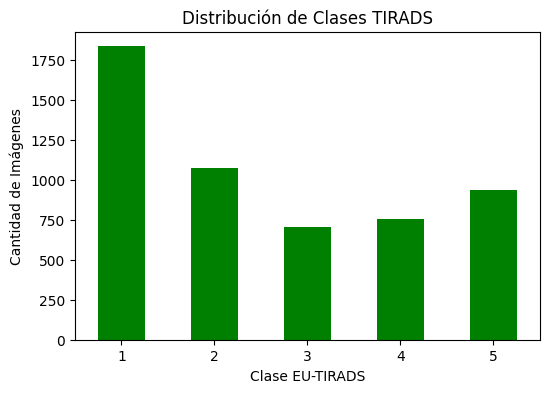

In [20]:
plt.figure(figsize=(6, 4))
tirads_counts.plot(kind='bar', color='green')
plt.title('Distribución de Clases TIRADS')
plt.xlabel('Clase EU-TIRADS')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=0)
plt.show()

**Interpretación:**

* Como se observa, la clase TIRADS 1 tiene la mayoría de las imágenes, lo que podría reflejar una distribución natural en la que las imágenes benignas son más comunes que las malignas.
* Identificación de desbalanceo de clases lo que podría afectar al modelo en pasos posteriores.
* Desde un punto de vista clínico, la mayor cantidad de imágenes pertenecientes a TIRADS 1 y TIRADS 2 sugiere que la mayoría de las personas con estos resultados de ultrasonido probablemente no tengan una condición peligrosa, lo que es coherente con la distribución de imágenes en los diagnósticos de ultrasonido de tiroides.

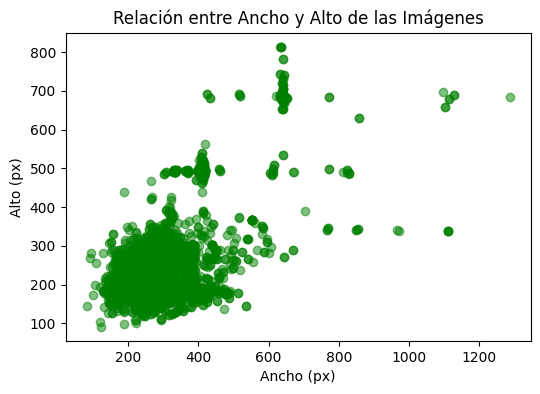

In [21]:
#filtramos las imágenes no válidas (usando la lista 'invalid_images')
images_df_plotSize = images_df[~images_df['Full_Path'].isin(invalid_images)]
 
plt.figure(figsize=(6, 4))
plt.scatter(
    images_df_plotSize['Image_Size'].apply(lambda x: x[0]), #ancho
    images_df_plotSize['Image_Size'].apply(lambda x: x[1]), #alto
    alpha=0.5, color='green'
)
plt.title('Relación entre Ancho y Alto de las Imágenes')
plt.xlabel('Ancho (px)')
plt.ylabel('Alto (px)')
plt.show()

**Interpretación:**

* La mayoría de las imágenes se agrupan en un rango de 200-400px de ancho y 100-400px de alto.
* Existen algunas imágenes mucho más grandes, con anchos de 600-1200px y altos de 700-800px. Estas son pocas en comparación con el resto del dataset.
* La mayoría de las imágenes son de tamaño moderado.
* Dispersión a la derecha: Indica imágenes con resolución mayor que son menos frecuentes.

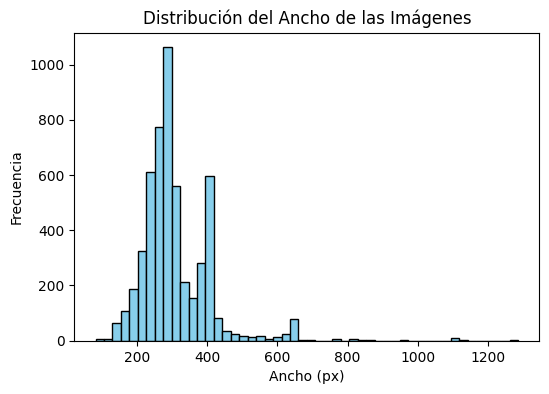

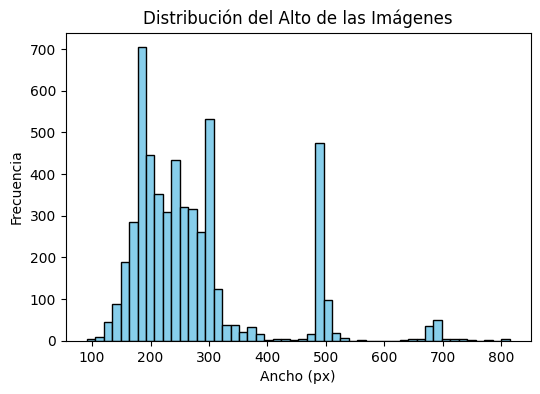

In [22]:
# Histograma del Ancho de las Imágenes
plt.figure(figsize=(6, 4))
plt.hist(
    images_df_plotSize['Image_Size'].apply(lambda x: x[0]),
    bins=50, color='skyblue', edgecolor='black'
)
plt.title('Distribución del Ancho de las Imágenes')
plt.xlabel('Ancho (px)')
plt.ylabel('Frecuencia')
plt.show()

# Histograma del Alto de las Imágenes
plt.figure(figsize=(6, 4))
plt.hist(
    images_df_plotSize['Image_Size'].apply(lambda x: x[1]),
    bins=50, color='skyblue', edgecolor='black'
)
plt.title('Distribución del Alto de las Imágenes')
plt.xlabel('Ancho (px)')
plt.ylabel('Frecuencia')
plt.show()

**Interpretación:**
* Histograma del Ancho de las Imágenes

    * La mayoría de las imágenes están en el rango de 200 a 400px de ancho, con una cola a la derecha que disminuye, lo que indica que las imágenes de mayor tamaño son más raras.
    * Sesgo a la derecha: El tamaño de las imágenes tiende a estar concentrado en un rango más pequeño.

* Histograma del Alto de las Imágenes
    * Similar al ancho, la mayoría de las imágenes tienen un alto entre 100 y 400px, con un pico alrededor de 480-500px.
    * La mayoría de las imágenes tienen un tamaño de alto moderado
    * El pico cerca de 480-500px sugiere que hay una concentración en ese rango de tamaño, pero el resto de la distribución sigue mostrando imágenes de diferentes tamaño.



**B. Revisión de Valores Nulos**

In [23]:
images_df['Tirads'].isnull().sum()

0

# **IV. Feature Engineering**

**A. Filtrado de imágenes inválidas**

Excluimos las imágenes que no se pueden procesar correctamente o que están marcadas como inválidas.

In [24]:
#filtramos el DataFrame para excluir las imágenes inválidas
images_df_filtrado = images_df[~images_df['Full_Path'].isin(invalid_images)].reset_index(drop=True)

In [25]:
print(images_df_filtrado.count())

Full_Path     5301
Tirads        5301
Image_Name    5301
Image_Size    5301
dtype: int64


**B. Revisión nuevamente de valores NaN, post filtrado**

In [26]:
print(images_df_filtrado['Tirads'].unique())  # Para ver los valores únicos de la columna
print(images_df_filtrado['Tirads'].isnull().sum())  # Para ver si hay valores nulos
print(images_df_filtrado.count())

[1 2 3 4 5]
0
Full_Path     5301
Tirads        5301
Image_Name    5301
Image_Size    5301
dtype: int64


In [27]:
images_df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5301 entries, 0 to 5300
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Full_Path   5301 non-null   object
 1   Tirads      5301 non-null   int64 
 2   Image_Name  5301 non-null   object
 3   Image_Size  5301 non-null   object
dtypes: int64(1), object(3)
memory usage: 165.8+ KB


**C. Creamos una copia de la estructura para continuar los próximos pasos**

In [28]:
images_df_filtrado_2 = images_df_filtrado[images_df['Tirads'].notna()].reset_index(drop=True)

C:\Users\rober\AppData\Local\Temp\ipykernel_17788\295678991.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_df_filtrado_2 = images_df_filtrado[images_df['Tirads'].notna()].reset_index(drop=True)


In [29]:
print(images_df_filtrado_2.head(2))

                                           Full_Path  Tirads      Image_Name  \
0  D:/Academico/Master Inteligencia Artificial - ...       1   tiroides1.jpg   
1  D:/Academico/Master Inteligencia Artificial - ...       1  tiroides10.jpg   

   Image_Size  
0  (289, 254)  
1  (276, 272)  


In [30]:
print(images_df_filtrado_2.count())

Full_Path     5301
Tirads        5301
Image_Name    5301
Image_Size    5301
dtype: int64


# **V. Desarrollo de Metodología**

### **A. Recolección y Preprocesamiento de Datos**

En esta sección preprocesaremos los datos, crearemos los métodos a nivel de redimensiones, normalizacion, balanceo de clases, data augmentation

##### **Balanceo de Clases**

Se creará una función de balanceo de clases, en donde se determinó la estrategia de tomar como referencia el minímo valor de todas las clases, y aplicarlo para todas las demas clases. Si bien estamos excluyendo data de otras clases mas reresentativas, fue el primer enfoque tomado para la homogeneidad de cantidades entre clases

In [33]:
def balance_classes(images_df):
    # Función para extraer el número de la imagen de su nombre
    def extract_image_number(image_name):
        # Usamos una expresión regular para extraer el número de la imagen
        match = re.search(r'(\d+)', image_name)
        if match:
            return int(match.group(1))
        return -1  #Si no se encuentra un número, devolvemos -1

    #creamos una columna nueva 'Image_Number' para almacenar los números extraídos
    images_df['Image_Number'] = images_df['Image_Name'].apply(extract_image_number)
    
    #ordenamos las imágenes en el dataframe por clase y número de imagen
    images_df_sorted = images_df.sort_values(by=['Tirads', 'Image_Number'])
    
    #obtenemos el número mínimo de imágenes por clase
    min_class_count = images_df['Tirads'].value_counts().min()

    #Seleccionaremos las primeras 'min_class_count' imágenes de cada clase
    balanced_images_df = images_df_sorted.groupby('Tirads').head(min_class_count).reset_index(drop=True)
    
    return balanced_images_df

In [34]:
# Uso de la función
balanced_images_df = balance_classes(images_df_filtrado_2)

In [35]:
#validamos cantidades originales
images_df_filtrado_2['Tirads'].value_counts()

Tirads
1    1835
2    1074
5     936
4     753
3     703
Name: count, dtype: int64

In [36]:
#revisamos las cantidades con balanceo
balanced_images_df['Tirads'].value_counts()

Tirads
1    703
2    703
3    703
4    703
5    703
Name: count, dtype: int64

In [37]:
# Mapeo de TI-RADS a valores numéricos
tirads_mapping = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4
}

In [38]:
#Converimos las etiquetas TI-RADS en números enteros
y = balanced_images_df['Tirads'].map(tirads_mapping)

In [39]:
print(y.head(5))

0    0
1    0
2    0
3    0
4    0
Name: Tirads, dtype: int64


##### **Redimensión y Normalización**

Aplicamos redimensionado y normalización de las imágenes para asegurarnos de que todas tengan el mismo tamaño y estén escaladas en el rango de 0 a 1. Esto optimizaría el rendimiento del modelo y facilitará el procesamiento eficiente de las imágenes durante el entrenamiento

In [40]:
# Función de Redimensionado y normalización de imágenes
def preprocess_images_normalizacion(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=target_size)  #redimensionamos
        img_array = image.img_to_array(img)  #convertimos a array de numpy
        img_array = img_array / 255.0  # Le cambiamos la escala entre 0 y 1
        images.append(img_array)
    return np.array(images)

##### **Split**

* Realizamos pruebas y finalmente optamos por usar la distribución 80/20

In [41]:
#Asignamos X
X = balanced_images_df['Full_Path'] 

In [42]:
#Realizamos el split en entrenamiento y el conjunto para pruebas/validacion, estratificando por clase (TI-RADS)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [43]:
#Realizamos el split de 10-10 sobre el 20% asignado a tmp, pero ahora distribidos en test y validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

##### **One Hot Encoding**

Aplicaremos One Hot Encoding (OHE) para convertir las etiquetas TIRADS 1, 2, 3, 4, 5 en vectores binarios, lo que permitirá que el modelo las procese correctamente durante el entrenamiento

In [44]:
#Convertimos las etiquetas a One-Hot Encoding
# Después de dividir los conjuntos, aplicamos One-Hot Encoding en las etiquetas Y
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=5)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=5)

In [45]:
#Verificamos los resultados
print(y_train_one_hot)

[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


**Revisamos las muestras distribuidas**

* Verificamos las cantidades TRAIN

In [46]:
y_train_series = pd.Series(np.argmax(y_train_one_hot, axis=1))
print(y_train_series.value_counts().sort_values())

3    562
2    562
0    562
1    563
4    563
Name: count, dtype: int64


In [47]:
#count total train
print(y_train_series.count())

2812


* Verificamos las cantidades VALIDATION

In [48]:
y_val_series = pd.Series(np.argmax(y_val_one_hot, axis=1))
print(y_val_series.value_counts().sort_values())

3    70
1    70
0    70
4    70
2    71
Name: count, dtype: int64


In [49]:
#count total Val
print(y_val_series.count())

351


* Verificamos las cantidades TEST

In [50]:
y_test_series = pd.Series(np.argmax(y_test_one_hot, axis=1))
print(y_test_series.value_counts().sort_values())

2    70
4    70
1    70
0    71
3    71
Name: count, dtype: int64


In [51]:
#count total test
print(y_test_series.count())

352


* Cargamos las imágenes preprocesadas, aplicando la redimensión y normalización

In [52]:
#carga de las imágenes preprocesadas
X_train_images = preprocess_images_normalizacion(X_train)
X_val_images = preprocess_images_normalizacion(X_val)
X_test_images = preprocess_images_normalizacion(X_test)

In [53]:
#Verificamos el tamaño nuevamente
print(f"Train shape: {X_train_images.shape}, Labels shape: {y_train_one_hot.shape}")
print(f"Val shape: {X_val_images.shape}, Labels shape: {y_val_one_hot.shape}")
print(f"Test shape: {X_test_images.shape}, Labels shape: {y_test_one_hot.shape}")

Train shape: (2812, 224, 224, 3), Labels shape: (2812, 5)
Val shape: (351, 224, 224, 3), Labels shape: (351, 5)
Test shape: (352, 224, 224, 3), Labels shape: (352, 5)


##### **EarlyStopping**

Se aplicará un early stopping para interrumpir el entrenamiento si la pérdida de validación no mejora durante 5 épocas consecutivas (patience=5), asegurando que el modelo mantenga los mejores pesos obtenidos

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

##### **Data Augmentation**

Aplicaremos Data Augmentation para generar variaciones de las imágenes mediante rotación, desplazamientos horizontales y verticales, y volteo horizontal, con el fin de aumentar la diversidad del conjunto de datos y mejorar la capacidad del modelo para generalizar.

Se aplicará a factor de 0.5 del total por cada clase

In [55]:
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotación más ligera
    width_shift_range=0.2,      # Desplazamiento horizontal pequeño
    height_shift_range=0.2,     # Desplazamiento vertical pequeño
    horizontal_flip=True,       # Voltear las imágenes horizontalmente
    fill_mode='nearest'         # Modo de relleno cercano para la distorsión
)

In [56]:
#Ajustamos el generador de Data Augmentation a las imágenes de entrenamiento
datagen.fit(X_train_images)

In [57]:
X_train_images.shape

(2812, 224, 224, 3)

In [58]:
#Definimos el número de nuevas muestras transformadas. En nuestro caso optamos por 0.5 adicional de la muestra 
num_nuevas_muestras_transformadas = int(len(X_train_images) * 0.5) 

In [59]:
print(num_nuevas_muestras_transformadas)

1406


In [60]:
# Creamos un generador para las imágenes aumentadas, con batch a 32
datagen_flow = datagen.flow(X_train_images, y_train_one_hot, batch_size=32)

In [61]:
print(datagen_flow)

In [62]:
#definimos las listas que almacenarán las muestras aumentadas
augmented_images = []
augmented_labels = []

In [63]:
#PRocedemos a usar el generador para crear nuevas imágenes aumentadas
for _ in range(num_nuevas_muestras_transformadas // 32):  # num_nuevas_muestras_transformadas / batch_size
    #obtenemos el siguiente lote de imágenes aumentadas
    img_batch, label_batch = next(datagen_flow)  
    #almacenamos las imágenes aumentadas
    augmented_images.append(img_batch)  
    #almacenamos las etiquetas aumentadas
    augmented_labels.append(label_batch)

In [64]:
# Convertimos las listas en arrays
augmented_images = np.vstack(augmented_images)  # Concatenamos las imágenes aumentadas
augmented_labels = np.vstack(augmented_labels)  # Concatenamos las etiquetas aumentadas

In [65]:
#Mostramos el tamaño de las imágenes aumentadas
print("Tamaño de las imágenes aumentadas:", augmented_images.shape)

Tamaño de las imágenes aumentadas: (1376, 224, 224, 3)


In [66]:
#Mostramos el tamaño por clase de los label aumentadas
print(pd.Series(np.argmax(augmented_labels, axis=1)).value_counts().sort_values())

1    262
0    265
2    266
4    287
3    296
Name: count, dtype: int64


- Unificamos las imágenes generadas a nuestro dataset origen

In [67]:
print(X_train_images.shape)
print(augmented_images.shape)
print(y_train_one_hot.shape)
print(augmented_labels.shape)

(2812, 224, 224, 3)
(1376, 224, 224, 3)
(2812, 5)
(1376, 5)


In [68]:
#Concatenamos ahora las imágenes originales con las aumentadas
X_train_combined = np.concatenate((X_train_images, augmented_images), axis=0)
y_train_combined = np.concatenate((y_train_one_hot, augmented_labels), axis=0)

In [69]:
#Imprimimos el nuevo tamaño después de la concatenación
print("Nuevo tamaño de imágenes de entrenamiento:", X_train_combined.shape)
print("Nuevo tamaño de etiquetas de entrenamiento:", y_train_combined.shape)

Nuevo tamaño de imágenes de entrenamiento: (4188, 224, 224, 3)
Nuevo tamaño de etiquetas de entrenamiento: (4188, 5)


In [70]:
print(pd.Series(np.argmax(y_train_combined, axis=1)).value_counts().sort_values())

1    825
0    827
2    828
4    850
3    858
Name: count, dtype: int64


### **B. Desarrollo, Entrenamiento y Evaluación del Modelo**

#### **Definición de Modelos**

En esta fase del desarrollo del modelo, se emplearán dos enfoques distintos para comparar su rendimiento en la clasificación de imágenes TI-RADS. Primero, se utilizará una Red Neuronal Convolucional (CNN) desde cero, con capas convolucionales y de pooling para extraer características relevantes de las imágenes, seguida de capas densas para la clasificación. En segundo lugar, se aplicarán modelos de Transfer Learning, utilizando arquitecturas preentrenadas como InceptionV3, VGG16, VGG19 y Xception. 

En este caso, se aprovecharán las capacidades de extracción de características de estos modelos preentrenados, congelando sus capas iniciales y añadiendo capas personalizadas para la clasificación final. Esta comparación permitirá evaluar cuál de los dos enfoques ofrece un mejor desempeño para el problema específico de clasificación TI-RADS.

#### **Entrenamiento y Evaluación del Modelo**

Para que se muestren los resultados (Entrenamiento + metricas de evaluación) por cada modelo, se optó por unificar esta parte en uno solo. 

Se definieron funciones para que sean invocadas por cada tipo de modelo y así se pueda visualizar todos los resultados asociados a cada uno de los modelos

- **Función para Arquitectura de model CNN**

* La red comienza con tres capas convolucionales. La primera capa utiliza 32 filtros de 3x3 para detectar características simples de las imágenes, seguida de una capa de MaxPooling con un tamaño de pool de 2x2 para reducir la resolución de las características extraídas. La segunda capa convolucional utiliza 64 filtros de 3x3, y nuevamente se aplica un MaxPooling de 2x2. La tercera capa, con 128 filtros de 3x3, sigue el mismo proceso de reducción de resolución con MaxPooling de 2x2. Estas tres capas convolucionales permiten que la red aprenda patrones espaciales cada vez más complejos y abstractos de las imágenes, mientras que el MaxPooling ayuda a reducir la complejidad computacional.

* Tras las capas convolucionales, la red incluye una capa densa (Fully Connected), que aplanará la salida de las capas convolucionales para convertirla en un vector unidimensional. Esta capa densa tiene 128 neuronas con una función de activación ReLU, lo que permite a la red realizar decisiones complejas basadas en las características que ha aprendido hasta ese momento.

* Para evitar el sobreajuste, se utiliza una técnica de Dropout del 50%, que desactiva aleatoriamente la mitad de las neuronas durante el entrenamiento, forzando al modelo a no depender demasiado de características específicas. Además, se aplica regularización L2 en las capas para penalizar los pesos grandes, lo que contribuye a mejorar la generalización del modelo.

* Finalmente, la capa de salida tiene 5 neuronas, una para cada clase TIRADS (1, 2, 3, 4, 5). Se utiliza una función de activación Softmax para generar probabilidades para cada clase, lo que permite que el modelo realice una clasificación multiclase.

* El modelo se compila utilizando el optimizador Adam, que ajusta automáticamente la tasa de aprendizaje durante el entrenamiento, y se utiliza categorical crossentropy como función de pérdida, adecuada para problemas de clasificación multiclase. La métrica seleccionada es precisión (accuracy), que evalúa qué tan bien el modelo predice correctamente las clases.

In [71]:
def create_modelo():
    model = Sequential()
    l2value = 0.001

    # Definimos el Input en la primera capa del modelo
    model.add(Input(shape=(224, 224, 3)))
    
    # Primera capa convolucional + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(l2value)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Segunda capa convolucional + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(l2value)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Tercera capa convolucional + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(l2value)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Capa completamente conectada (Fully Connected) para la clasificación
    model.add(Flatten())  # Aplanamos las salidas de la capa convolucional
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(l2value)))  # Capa densa con 512 neuronas
    
    #Dropout para evitar sobreajuste
    model.add(Dropout(0.5))
    
    model.add(Dense(5, activation='softmax',kernel_regularizer=l2(l2value)))  # 5 clases para clasificación TI-RADS

    # Compilamos el modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

* **Función para Arquitecturas de modelos de TransferLearning**

Se emplea un enfoque de Transfer Learning, utilizando un modelo preentrenado como base para aprovechar los patrones ya aprendidos en grandes conjuntos de datos. Este modelo se congela para evitar que sus pesos se actualicen durante el entrenamiento, y se añaden capas personalizadas para ajustarse al problema específico de clasificación de imágenes TI-RADS.

* Congelación del Modelo Base:

Se comienza utilizando un modelo preentrenado (como VGG16, InceptionV3, etc.) como base. Las capas del modelo base se congelan, lo que significa que no se entrenan ni modifican durante el proceso, permitiendo que el modelo aproveche las características ya aprendidas de grandes datasets como ImageNet.

* Añadido de Capas Convolucionales Personalizadas:

Después de la parte congelada, se añaden capas convolucionales adicionales para mejorar la capacidad de generalización del modelo. Estas capas detectan características adicionales específicas del conjunto de datos TI-RADS.

* Conv2D: Se añaden varias capas convolucionales con activación ReLU y regularización L2 para evitar el sobreajuste, y con un tamaño de filtro de 3x3.

* El uso de padding 'same' asegura que las dimensiones de las imágenes no cambien tras pasar por las capas convolucionales.

* Capa de Aplanado y Densa:

    * Flatten(): Convierte la salida de las capas convolucionales en un vector unidimensional, adecuado para pasar a la siguiente capa densa.
    * Capa densa: Se agrega una capa densa con 128 neuronas y activación ReLU para aprender representaciones más complejas.

* Dropout para Regularización:

Para evitar el sobreajuste, se utiliza una técnica de dropout del 50%, desactivando aleatoriamente la mitad de las neuronas durante el entrenamiento.

* Capa de Salida:

La capa de salida tiene 5 neuronas (una por cada clase TI-RADS) y usa la función de activación softmax para calcular las probabilidades de cada clase, con lo que el modelo hace la clasificación final.

* Compilación del Modelo:

El modelo se compila con el optimizador Adam, que ajusta la tasa de aprendizaje, y la función de pérdida categorical_crossentropy, adecuada para clasificación multiclase.

* Métricas: Se utiliza precisión (accuracy) como métrica de evaluación del modelo.

In [72]:
def create_modelo_with_transferlearning(base_model, num_classes=5, l2value=0.01):
    # Congelamos las capas del modelo base para evitar su actualización durante el entrenamiento
    base_model.trainable = False  # Esto es importante para no modificar las capas preentrenadas

    # Creamos un modelo secuencial
    model = Sequential()
    
    # Añadimos el modelo base (Transfer Learning)
    model.add(base_model)

    # Ahora añadimos las capas personalizadas (convolucionales)
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2value))) 

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2value))) 

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2value))) 

    # Capa completamente conectada para la clasificación
    model.add(Flatten())  # Aplanar la salida de las capas convolucionales
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2value)))  # Capa densa

    # Dropout para evitar el sobreajuste
    model.add(Dropout(0.5))

    # Capa de salida con 5 clases para TI-RADS
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2value)))

    # Compilamos el modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

* **Función para Mostrar la pérdida y precisión durante entrenamiento**
    
Esta función visualiza el historial de entrenamiento mostrando las curvas de pérdida y precisión tanto para el conjunto de entrenamiento como para el de validación, permitiendo evaluar el desempeño del modelo a lo largo de las épocas

In [73]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='Pérdida (Validation)')
    plt.plot(history.history['loss'], label='Pérdida (Train)')
    plt.title('Comparativa de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='Precisión (Validation)')
    plt.plot(history.history['accuracy'], label='Precisión (Train)')
    plt.title('Comparativa de Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.show()

* **Función de Mostrar la Evaluación de cada modelo con sus métricas respectivas**

Esta función evalúa el rendimiento del modelo en el conjunto de prueba, calculando la precisión, el AUC y el recall para cada clase, y generando las curvas ROC. Además, devuelve un reporte de clasificación detallado con las métricas para cada clase, así como el AUC y el recall total promedio. 

Al final, se visualizan las curvas ROC y un gráfico de barras con el recall por clase para una mejor interpretación del desempeño del modelo.

In [74]:
def evaluate_model(model, X_test_images, y_test, num_classes=5):
    # Evaluación en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(X_test_images, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Predicciones del modelo
    y_pred = model.predict(X_test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_test, axis=1)  # Convertir las etiquetas One-Hot a clases
    
    # Generamos reporte de clasificación
    report = classification_report(y_true, y_pred_classes, target_names=['1', '2', '3', '4', '5'])
    print("Reporte de Clasificación:")
    print(report)

    # Calculamos AUC por clase
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):  # Asumiendo 5 clases 
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])  # Usamos las probabilidades de cada clase
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Mostramos AUC por clase
    print("\nAUC por clase:")
    for i in range(num_classes):
        print(f'Clase {i+1} (AUC = {roc_auc[i]:.5f})')

    # AUC total (promedio ponderado)
    auc_total = np.mean(list(roc_auc.values()))
    print(f"AUC Total: {auc_total:.5f}")

    # Calculamos Recall por clase
    recall_per_class = recall_score(y_true, y_pred_classes, average=None)
    print("\nRecall por clase:")
    for i in range(num_classes):
        print(f'Clase {i+1} (Recall = {recall_per_class[i]:.5f})')

    # Recall total (promedio ponderado)
    recall_total = np.mean(recall_per_class)
    print(f"Recall Total: {recall_total:.5f}")



    # Graficamos Recall por clase
    plt.figure(figsize=(8, 6))
    plt.bar(range(num_classes), recall_per_class, tick_label=['1', '2', '3', '4', '5'], color='skyblue')
    plt.xlabel('Clases')
    plt.ylabel('Recall')
    plt.title('Recall por clase')
    plt.show()
    
    # Graficamos las curvas ROC para cada clase
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatorio')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC por clase')
    plt.legend(loc='lower right')
    plt.show()


    return {'AUC': roc_auc, 'Recall': recall_per_class, 'AUC Total': auc_total, 'Recall Total': recall_total}

**--------------------------------------------------------------------**

**1. MODELO CNN**

**--------------------------------------------------------------------**

Procedemos a aplicar la arquitectura CNN con las capas indicadas, tomando como referencia el set de datos original (train+test), sin data augmentation

**1.1. Con Data Augmentation**

- Declaración

In [78]:
#Inicializamos el modelo
model1 = create_modelo()

In [79]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,077 (49.36 MB)

 Trainable params: 12,939,077 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

* Entrenamiento

In [80]:
#Entrenamos el modelo con las imágenes originales y aumentadas
history_conDataAug = model1.fit(
                    X_train_combined, y_train_combined
                    ,epochs=20
                    #,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 642ms/step - accuracy: 0.2152 - loss: 2.0520 - val_accuracy: 0.3248 - val_loss: 1.6508
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 590ms/step - accuracy: 0.2972 - loss: 1.6817 - val_accuracy: 0.3989 - val_loss: 1.5129
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 600ms/step - accuracy: 0.4082 - loss: 1.5276 - val_accuracy: 0.4160 - val_loss: 1.4446
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 586ms/step - accuracy: 0.4386 - loss: 1.4777 - val_accuracy: 0.5014 - val_loss: 1.4158
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 584ms/step - accuracy: 0.4766 - loss: 1.4034 - val_accuracy: 0.5242 - val_loss: 1.3843
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 588ms/step - accuracy: 0.4963 - loss: 1.3622 - val_accuracy: 0.5584 - val_loss: 1.3631
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 630ms/step - accuracy: 0.5337 - loss: 1.3087 - val_accuracy: 0.5071 - val_loss: 1.4499
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 608ms/step - accuracy: 0.5741 - loss: 1

* Gráfico de Curvas de Pérdida y Precisión

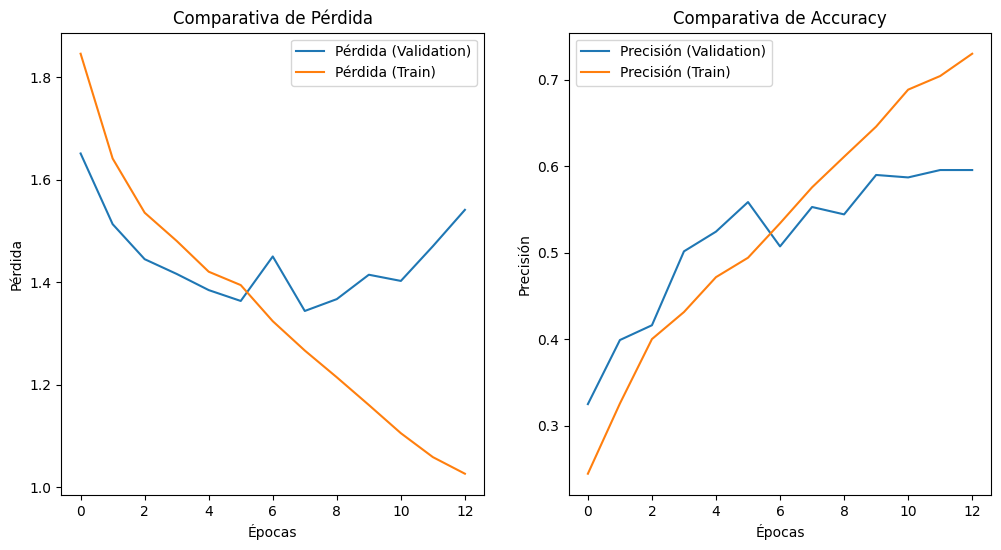

In [81]:
plot_training_history(history_conDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5775 - loss: 1.3987
Test Accuracy: 59.09%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.54      0.63      0.58        71
           2       0.58      0.51      0.55        70
           3       0.49      0.44      0.47        70
           4       0.54      0.58      0.56        71
           5       0.81      0.79      0.80        70

    accuracy                           0.59       352
   macro avg       0.59      0.59      0.59       352
weighted avg       0.59      0.59      0.59       352


AUC por clase:
Clase 1 (AUC = 0.85119)
Clase 2 (AUC = 0.81231)
Clase 3 (AUC = 0.78994)
Clase 4 (AUC = 0.81577)
Clase 5 (AUC = 0.92482)
AUC Total: 0.83881

Recall por clase:
Clase 1 (Recall = 0.63380)
Clase 2 (Recall = 0.51429)
Clase 3 (Recall = 0.44286)
Clase 4 (Recall = 0.57746)
Clase 5 (Recall = 0.78571)
Recall Total: 0.59082


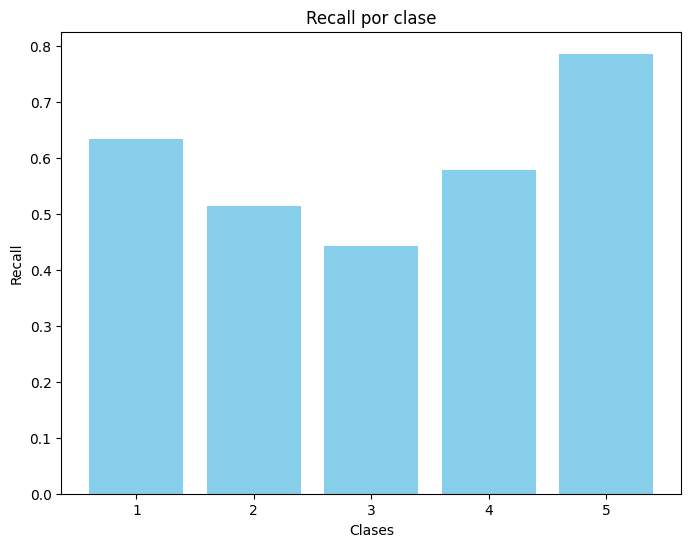

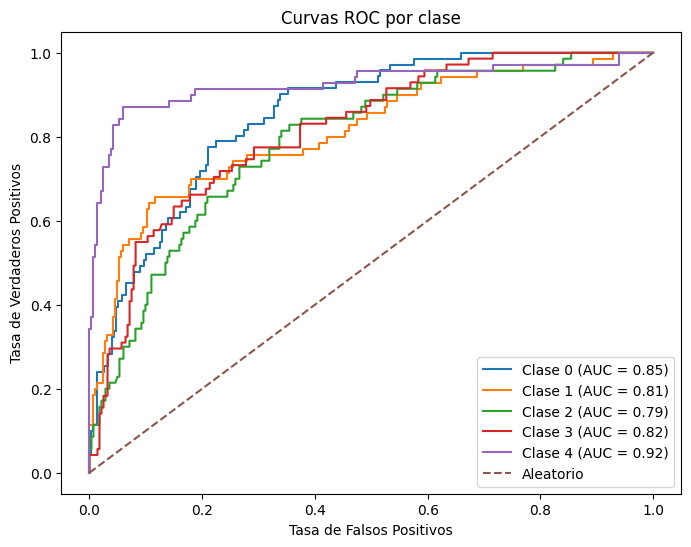

{'AUC': {0: 0.8511854042403889,
  1: 0.8123100303951367,
  2: 0.7899442755825735,
  3: 0.8157736454313067,
  4: 0.924822695035461},
 'Recall': array([0.63380282, 0.51428571, 0.44285714, 0.57746479, 0.78571429]),
 'AUC Total': 0.8388072101369733,
 'Recall Total': 0.5908249496981891}

In [82]:
evaluate_model(model1, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [84]:
model1.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_cnn_augm.h5')

**1.2. Sin Data Augmentation**

In [85]:
model2 = create_modelo()

In [86]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,077 (49.36 MB)

 Trainable params: 12,939,077 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

- Entrenamiento

In [87]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_sinDataAug = model2.fit(X_train_images, y_train_one_hot
                    ,epochs=20
                    ,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 584ms/step - accuracy: 0.2496 - loss: 2.1022 - val_accuracy: 0.2764 - val_loss: 1.7086
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 599ms/step - accuracy: 0.3119 - loss: 1.6626 - val_accuracy: 0.3932 - val_loss: 1.5292
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 587ms/step - accuracy: 0.3912 - loss: 1.5236 - val_accuracy: 0.4131 - val_loss: 1.4884
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 590ms/step - accuracy: 0.4415 - loss: 1.4498 - val_accuracy: 0.4615 - val_loss: 1.4509
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 593ms/step - accuracy: 0.4989 - loss: 1.3747 - val_accuracy: 0.5100 - val_loss: 1.3798
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 592ms/step - accuracy: 0.5152 - loss: 1.3196 - val_accuracy: 0.5100 - val_loss: 1.4127
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 594ms/step - accuracy: 0.5883 - loss: 1.2415 - val_accuracy: 0.5014 - val_loss: 1.4213
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 588ms/step - accuracy: 0.6074 - loss: 1.1569 - val_accu

- Gráfico de Curvas de Pérdida y Precisión

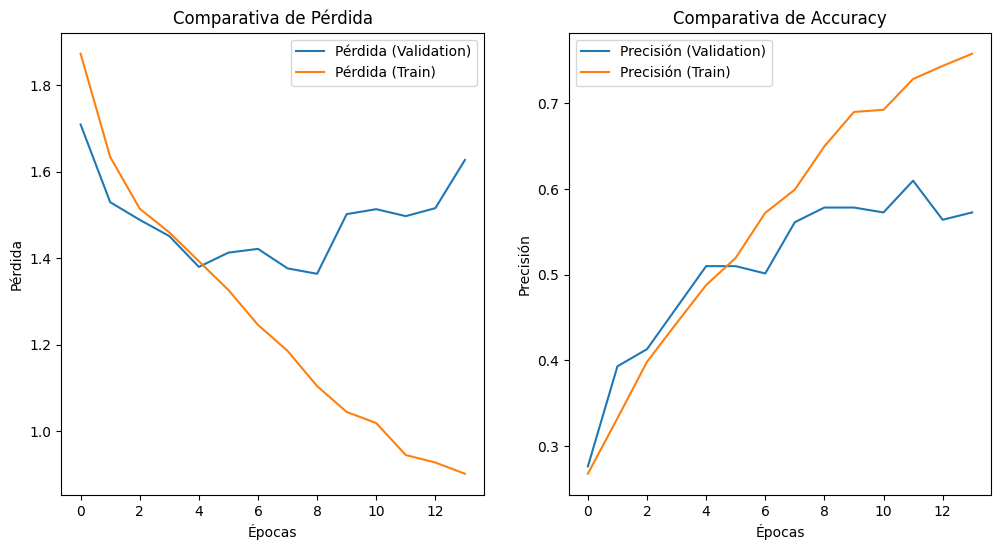

In [88]:
plot_training_history(history_sinDataAug)

- Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5861 - loss: 1.3571
Test Accuracy: 57.95%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.46      0.66      0.54        71
           2       0.55      0.46      0.50        70
           3       0.51      0.56      0.53        70
           4       0.63      0.44      0.52        71
           5       0.82      0.79      0.80        70

    accuracy                           0.58       352
   macro avg       0.60      0.58      0.58       352
weighted avg       0.60      0.58      0.58       352


AUC por clase:
Clase 1 (AUC = 0.82873)
Clase 2 (AUC = 0.80405)
Clase 3 (AUC = 0.81335)
Clase 4 (AUC = 0.81372)
Clase 5 (AUC = 0.93131)
AUC Total: 0.83823

Recall por clase:
Clase 1 (Recall = 0.66197)
Clase 2 (Recall = 0.45714)
Clase 3 (Recall = 0.55714)
Clase 4 (Recall = 0.43662)
Clase 5 (Recall = 0.78571)
Recall Total: 0.57972


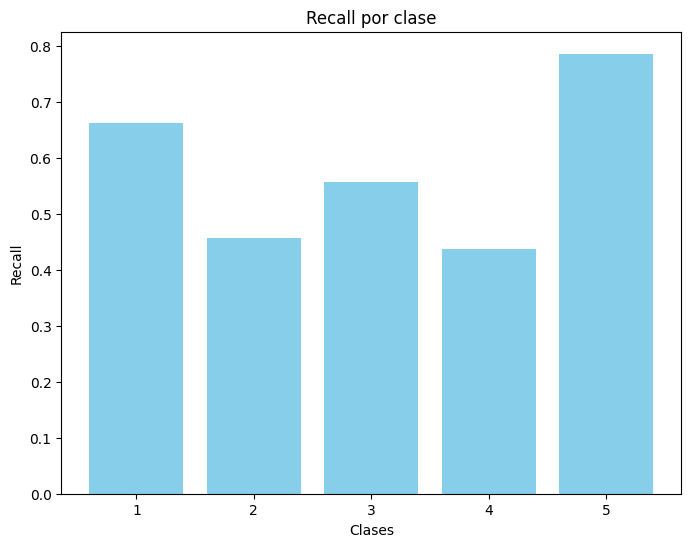

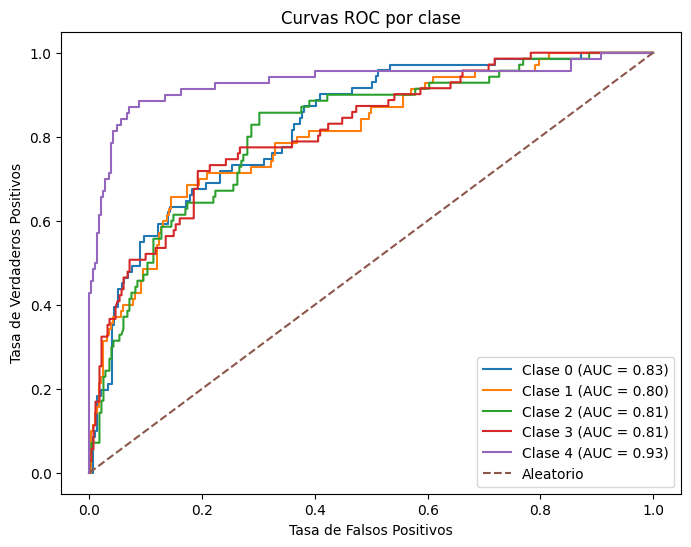

{'AUC': {0: 0.8287303894541627,
  1: 0.8040526849037488,
  2: 0.8133485309017223,
  3: 0.8137186105959601,
  4: 0.9313069908814589},
 'Recall': array([0.66197183, 0.45714286, 0.55714286, 0.43661972, 0.78571429]),
 'AUC Total': 0.8382314413474106,
 'Recall Total': 0.5797183098591548}

In [89]:
evaluate_model(model2, X_test_images, y_test_one_hot, num_classes=5)

- Guardamos el modelo

In [90]:
model2.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_cnn.h5')

**--------------------------------------------------------------------**

**2. MODELO VGG16**

**--------------------------------------------------------------------**

VGG16 es un modelo de Transfer Learning que cuenta con 13 capas convolucionales profundas, diseñadas para extraer características complejas de las imágenes.

**2.1. Con Data Augmentation**

* Declaración

In [91]:
#cargamos el modelo VGG16 preentrenado sin la capa superior (classifier)
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [92]:
#Creamos el modelo con Transfer Learning y capas personalizadas
model_vgg16 = create_modelo_with_transferlearning(base_model_VGG16, num_classes=5, l2value=0.001)

In [93]:
# Resumen del modelo
model_vgg16.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,598,373 (59.50 MB)

 Trainable params: 883,685 (3.37 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

* Entrenamiento

In [94]:
#Entrenamos el modelo con las imágenes originales y aumentadas
history_VGG16_conDataAug = model_vgg16.fit(
                    X_train_combined, y_train_combined
                    ,epochs=20
                    #,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.2500 - loss: 2.0126 - val_accuracy: 0.3875 - val_loss: 1.6101
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.3718 - loss: 1.6097 - val_accuracy: 0.3960 - val_loss: 1.5092
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.4235 - loss: 1.4613 - val_accuracy: 0.4245 - val_loss: 1.3536
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.4418 - loss: 1.3672 - val_accuracy: 0.4274 - val_loss: 1.3552
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.4872 - loss: 1.2787 - val_accuracy: 0.4359 - val_loss: 1.3152
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.5049 - loss: 1.2405 - val_accuracy: 0.4872 - val_loss: 1.3135
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.5147 - loss: 1.2374 - val_accuracy: 0.4758 - val_loss: 1.2929
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.5540 - loss: 1.1680 - val_accu

* Gráfico de Curvas de Pérdida y Precisión

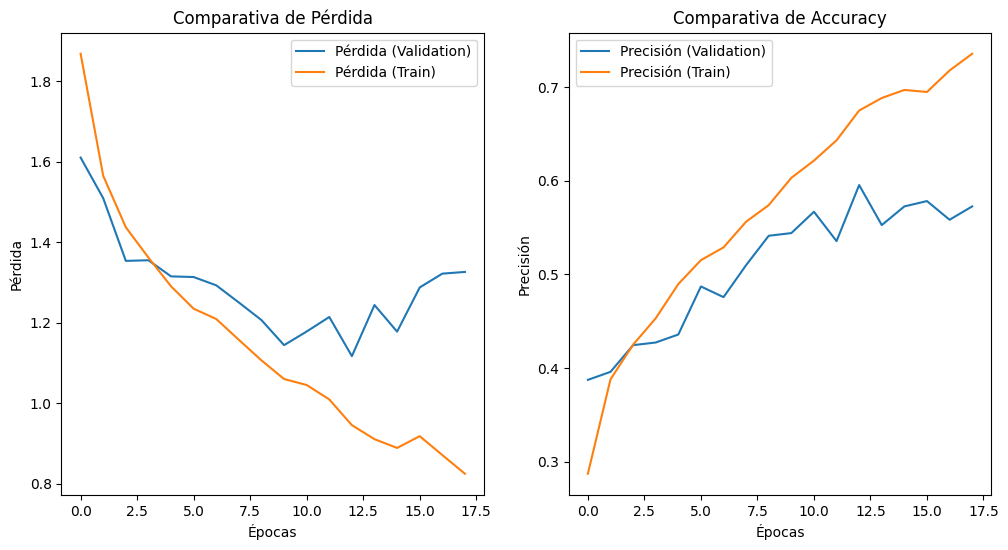

In [95]:
plot_training_history(history_VGG16_conDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5238 - loss: 1.2192
Test Accuracy: 55.97%
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.69      0.73      0.71        71
           2       0.64      0.60      0.62        70
           3       0.42      0.49      0.45        70
           4       0.34      0.30      0.32        71
           5       0.69      0.69      0.69        70

    accuracy                           0.56       352
   macro avg       0.56      0.56      0.56       352
weighted avg       0.56      0.56      0.56       352


AUC por clase:
Clase 1 (AUC = 0.93173)
Clase 2 (AUC = 0.87285)
Clase 3 (AUC = 0.77505)
Clase 4 (AUC = 0.80024)
Clase 5 (AUC = 0.90932)
AUC Total: 0.85784

Recall por clase:
Clase 1 (Recall = 0.73239)
Clase 2 (Recall = 0.60000)
Clase 3 (Recall = 0.48571)
Clase 4 (Recall = 0.29577)
Clase 5 (Recall = 0.68571)
Recall Total: 0.55992


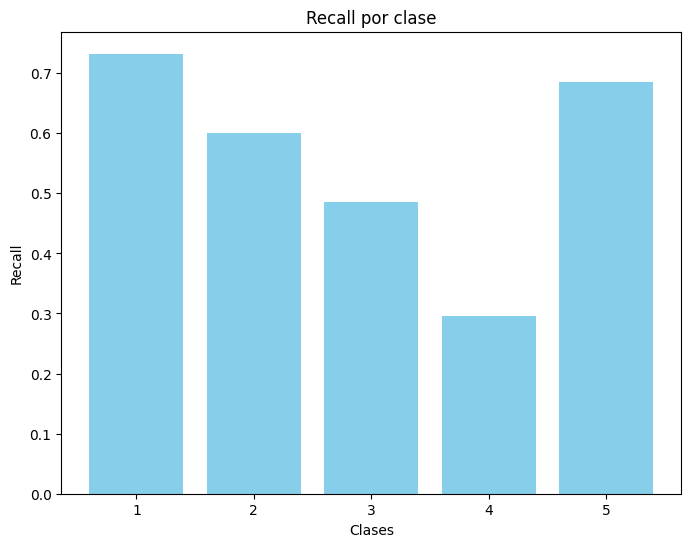

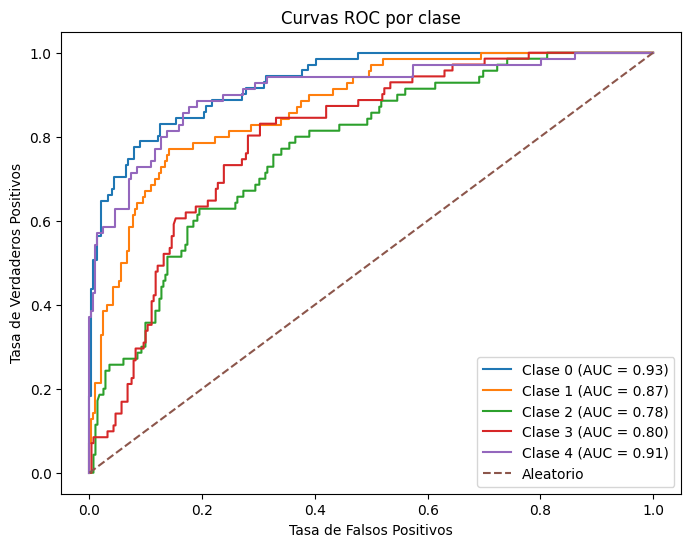

{'AUC': {0: 0.9317327452258032,
  1: 0.8728470111448834,
  2: 0.775050658561297,
  3: 0.8002355771640519,
  4: 0.9093211752786221},
 'Recall': array([0.73239437, 0.6       , 0.48571429, 0.29577465, 0.68571429]),
 'AUC Total': 0.8578374334749315,
 'Recall Total': 0.5599195171026157}

In [96]:
evaluate_model(model_vgg16, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo


In [97]:
model_vgg16.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_vgg16_augm.h5')

**2.2. Sin Data Augmentation**

* Declaración

In [98]:
# Cargar el modelo VGG16 preentrenado sin la capa superior (classifier)
base_model_VGG16_2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [99]:
# Crear el modelo con Transfer Learning y capas personalizadas
model_vgg16_2 = create_modelo_with_transferlearning(base_model_VGG16_2, num_classes=5, l2value=0.001)

In [100]:
# Resumen del modelo
model_vgg16_2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,598,373 (59.50 MB)

 Trainable params: 883,685 (3.37 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

* Entrenamiento

In [101]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_VGG16_sinDataAug = model_vgg16_2.fit(X_train_images, y_train_one_hot
                    ,epochs=20
                    ,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.2334 - loss: 2.0548 - val_accuracy: 0.3789 - val_loss: 1.6931
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.3741 - loss: 1.6035 - val_accuracy: 0.4387 - val_loss: 1.4714
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.4210 - loss: 1.4467 - val_accuracy: 0.4758 - val_loss: 1.3564
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.4809 - loss: 1.3291 - val_accuracy: 0.4558 - val_loss: 1.3865
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.5105 - loss: 1.2432 - val_accuracy: 0.5214 - val_loss: 1.3226
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.5636 - loss: 1.1881 - val_accuracy: 0.4957 - val_loss: 1.2690
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.5651 - loss: 1.1727 - val_accuracy: 0.5071 - val_loss: 1.2766
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.6091 - loss: 1.0859 - val_accuracy: 0.5413 - v

* Gráfico de Curvas de Pérdida y Precisión

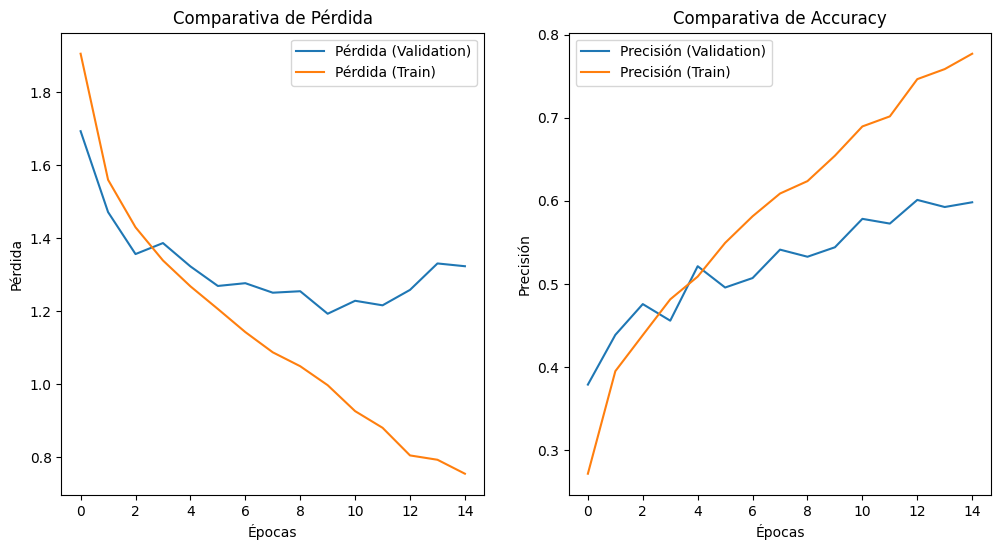

In [102]:
plot_training_history(history_VGG16_sinDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5423 - loss: 1.2665
Test Accuracy: 57.10%
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.62      0.79      0.70        71
           2       0.65      0.60      0.62        70
           3       0.47      0.29      0.35        70
           4       0.43      0.56      0.48        71
           5       0.72      0.61      0.66        70

    accuracy                           0.57       352
   macro avg       0.58      0.57      0.56       352
weighted avg       0.57      0.57      0.56       352


AUC por clase:
Clase 1 (AUC = 0.90787)
Clase 2 (AUC = 0.86383)
Clase 3 (AUC = 0.73609)
Clase 4 (AUC = 0.81643)
Clase 5 (AUC = 0.89762)
AUC Total: 0.84437

Recall por clase:
Clase 1 (Recall = 0.78873)
Clase 2 (Recall = 0.60000)
Clase 3 (Recall = 0.28571)
Clase 4 (Recall = 0.56338)
Clase 5 (Recall = 0.61429)
Recall Total: 0.57042


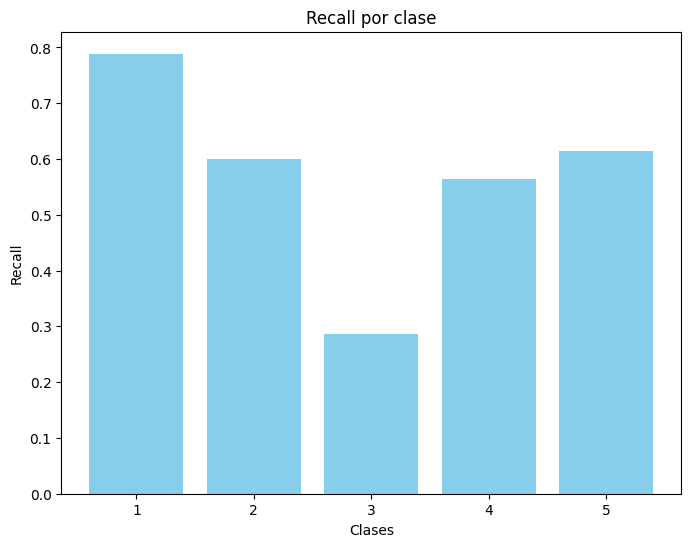

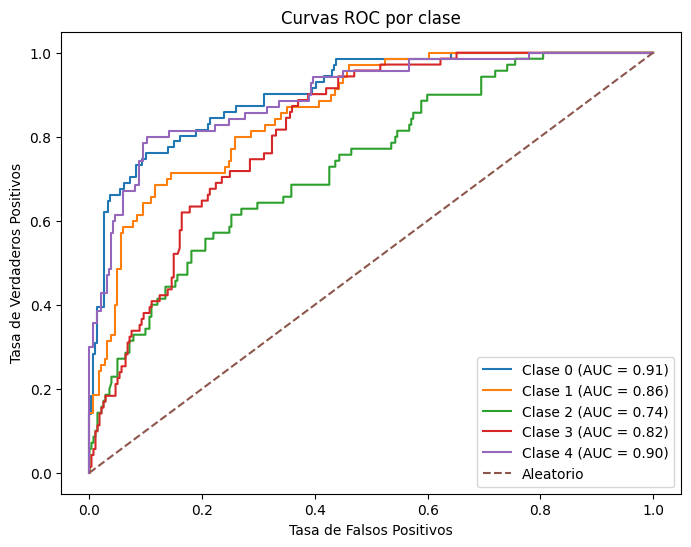

{'AUC': {0: 0.9078742920154379,
  1: 0.8638297872340426,
  2: 0.7360942249240121,
  3: 0.8164252418425141,
  4: 0.8976190476190476},
 'Recall': array([0.78873239, 0.6       , 0.28571429, 0.56338028, 0.61428571]),
 'AUC Total': 0.8443685187270109,
 'Recall Total': 0.5704225352112676}

In [103]:
evaluate_model(model_vgg16_2, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [104]:
model_vgg16_2.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_vgg16.h5')

**--------------------------------------------------------------------**

**3. MODELO VGG19**

**--------------------------------------------------------------------**

VGG19 es un modelo de Transfer Learning que cuenta con 19 capas convolucionales profundas, diseñadas para extraer características más complejas de las imágenes. 

Su arquitectura más profunda permite capturar patrones más detallados, lo que puede ser útil para problemas de clasificación más complejos.


**3.1. Con Data Augmentation**

* Declaración

In [105]:
#Cargamos el modelo VGG19 preentrenado sin la capa superior (classifier)
base_model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [106]:
#Creamos el modelo con Transfer Learning y capas personalizadas
model_vgg19 = create_modelo_with_transferlearning(base_model_VGG19, num_classes=5, l2value=0.001)

In [107]:
# Resumen del modelo
model_vgg19.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,908,069 (79.76 MB)

 Trainable params: 883,685 (3.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

* Entrenamiento

In [108]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_VGG19_conDataAug = model_vgg19.fit(X_train_combined, y_train_combined
                    ,epochs=20
                    #,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - accuracy: 0.2124 - loss: 2.0111 - val_accuracy: 0.3305 - val_loss: 1.5697
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 516s 4s/step - accuracy: 0.3865 - loss: 1.5728 - val_accuracy: 0.4274 - val_loss: 1.4658
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.4062 - loss: 1.4695 - val_accuracy: 0.4245 - val_loss: 1.3974
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.4466 - loss: 1.3904 - val_accuracy: 0.4017 - val_loss: 1.3527
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.4610 - loss: 1.3432 - val_accuracy: 0.4359 - val_loss: 1.3600
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.4823 - loss: 1.2795 - val_accuracy: 0.4558 - val_loss: 1.2797
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.5060 - loss: 1.2494 - val_accuracy: 0.4872 - val_loss: 1.2774
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.5245 - loss: 1.2053 - val_accu

* Gráfico de Curvas de Pérdida y Precisión

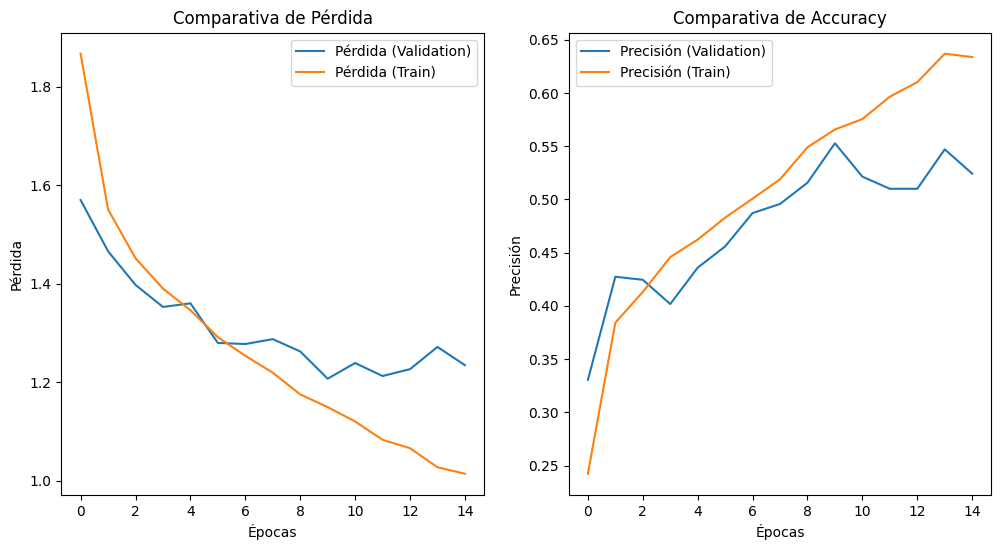

In [109]:
plot_training_history(history_VGG19_conDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5172 - loss: 1.3316
Test Accuracy: 53.41%
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.65      0.75      0.70        71
           2       0.52      0.54      0.53        70
           3       0.36      0.17      0.23        70
           4       0.42      0.49      0.45        71
           5       0.61      0.71      0.66        70

    accuracy                           0.53       352
   macro avg       0.51      0.53      0.51       352
weighted avg       0.51      0.53      0.52       352


AUC por clase:
Clase 1 (AUC = 0.90026)
Clase 2 (AUC = 0.83688)
Clase 3 (AUC = 0.68427)
Clase 4 (AUC = 0.77372)
Clase 5 (AUC = 0.88095)
AUC Total: 0.81522

Recall por clase:
Clase 1 (Recall = 0.74648)
Clase 2 (Recall = 0.54286)
Clase 3 (Recall = 0.17143)
Clase 4 (Recall = 0.49296)
Clase 5 (Recall = 0.71429)
Recall Total: 0.53360


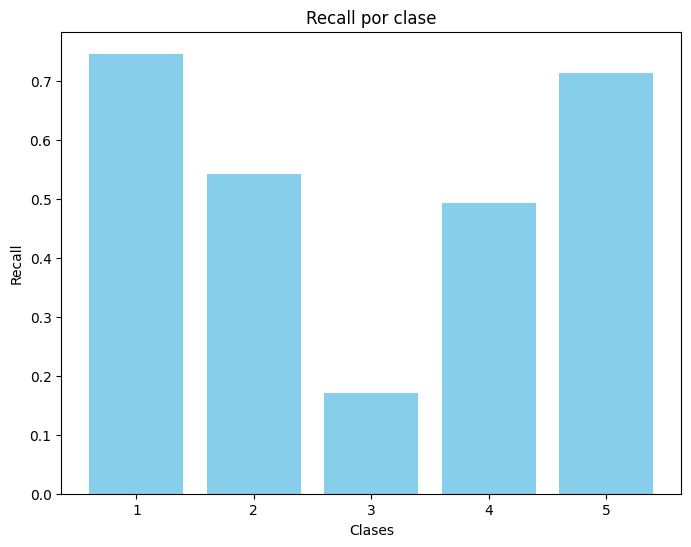

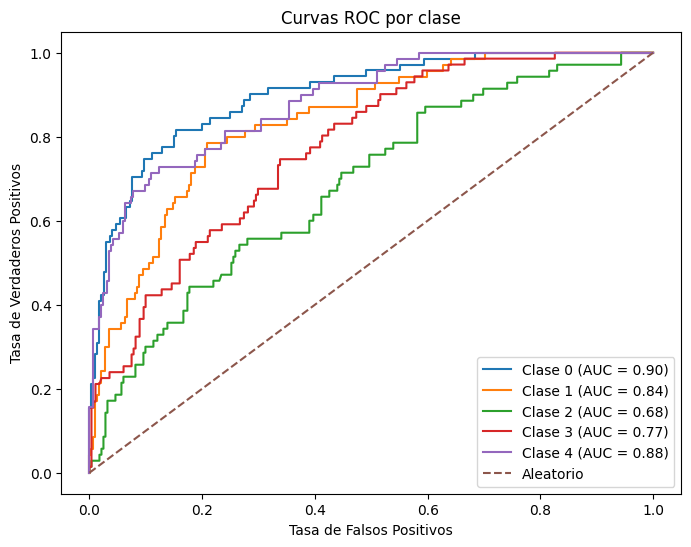

{'AUC': {0: 0.9002556262843968,
  1: 0.8368794326241135,
  2: 0.6842705167173252,
  3: 0.7737206155079945,
  4: 0.8809523809523809},
 'Recall': array([0.74647887, 0.54285714, 0.17142857, 0.49295775, 0.71428571]),
 'AUC Total': 0.815215714417242,
 'Recall Total': 0.5336016096579477}

In [110]:
evaluate_model(model_vgg19, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [111]:
model_vgg19.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_vgg19_augm.h5')

**3.2. Sin Data Augmentation**

* Declaración

In [112]:
# Cargar el modelo VGG19 preentrenado sin la capa superior (classifier)
base_model_VGG19_2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [113]:
# Crear el modelo con Transfer Learning y capas personalizadas
model_vgg19_2 = create_modelo_with_transferlearning(base_model_VGG19_2, num_classes=5, l2value=0.001)

In [114]:
# Resumen del modelo
model_vgg19_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,908,069 (79.76 MB)

 Trainable params: 883,685 (3.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

* Entrenamiento

In [116]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_VGG19_sinDataAug = model_vgg19_2.fit(
                    X_train_images, y_train_one_hot
                    ,epochs=20
                    ,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.2070 - loss: 2.0788 - val_accuracy: 0.2108 - val_loss: 1.8365
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.2184 - loss: 1.8145 - val_accuracy: 0.3590 - val_loss: 1.6233
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.3502 - loss: 1.5832 - val_accuracy: 0.3675 - val_loss: 1.4959
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.3928 - loss: 1.4857 - val_accuracy: 0.4330 - val_loss: 1.4116
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.4451 - loss: 1.3800 - val_accuracy: 0.4473 - val_loss: 1.3711
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.4805 - loss: 1.2897 - val_accuracy: 0.4644 - val_loss: 1.3548
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.5002 - loss: 1.2778 - val_accuracy: 0.4444 - val_loss: 1.3757
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.5250 - loss: 1.2313 - val_accuracy: 0.4957 - v

* Gráfico de Curvas de Pérdida y Precisión

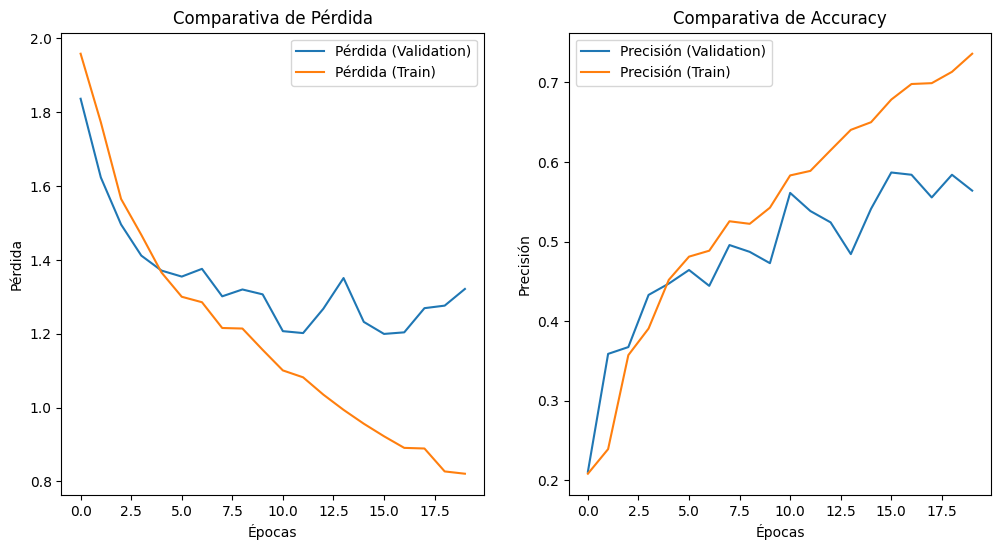

In [117]:
plot_training_history(history_VGG19_sinDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5746 - loss: 1.3343
Test Accuracy: 59.09%
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.69      0.80      0.74        71
           2       0.57      0.56      0.57        70
           3       0.43      0.43      0.43        70
           4       0.50      0.48      0.49        71
           5       0.75      0.69      0.72        70

    accuracy                           0.59       352
   macro avg       0.59      0.59      0.59       352
weighted avg       0.59      0.59      0.59       352


AUC por clase:
Clase 1 (AUC = 0.92030)
Clase 2 (AUC = 0.86028)
Clase 3 (AUC = 0.72586)
Clase 4 (AUC = 0.82685)
Clase 5 (AUC = 0.91829)
AUC Total: 0.85032

Recall por clase:
Clase 1 (Recall = 0.80282)
Clase 2 (Recall = 0.55714)
Clase 3 (Recall = 0.42857)
Clase 4 (Recall = 0.47887)
Clase 5 (Recall = 0.68571)
Recall Total: 0.59062


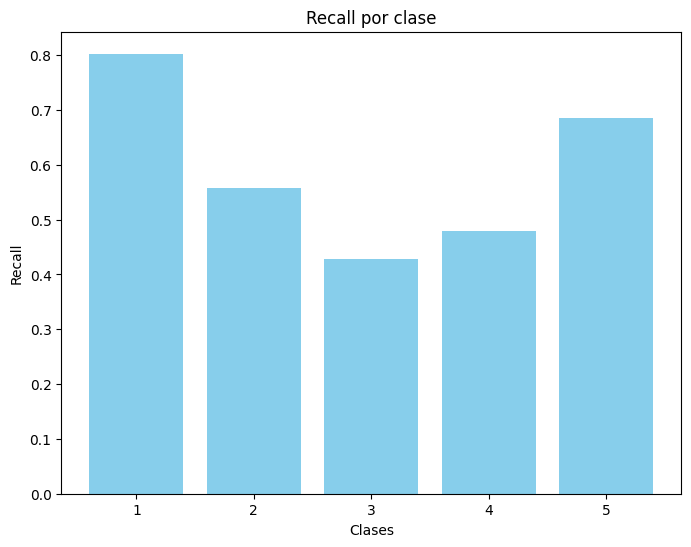

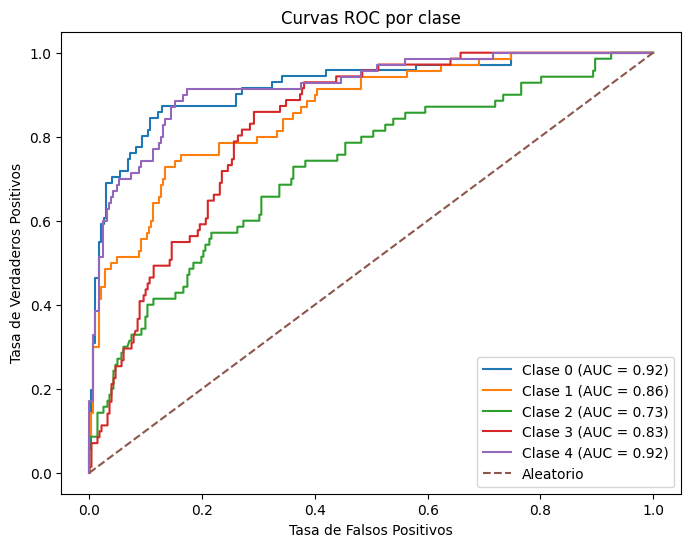

{'AUC': {0: 0.9203047466292416,
  1: 0.8602836879432624,
  2: 0.7258611955420466,
  3: 0.8268507844218335,
  4: 0.9182877406281662},
 'Recall': array([0.8028169 , 0.55714286, 0.42857143, 0.47887324, 0.68571429]),
 'AUC Total': 0.8503176310329101,
 'Recall Total': 0.5906237424547284}

In [118]:
evaluate_model(model_vgg19_2, X_test_images, y_test_one_hot, num_classes=5)

 - Guardamos el modelo

In [141]:
model_vgg19_2.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_vgg19.h5')

**--------------------------------------------------------------------**

**4. MODELO InceptionV3**

**--------------------------------------------------------------------**

InceptionV3 utiliza módulos de convolución de diferentes tamaños y concatenación de capas, lo que le permite capturar una mayor diversidad de características a distintas escalas.

**4.1. Con Data Augmentation**

* Declaración

In [120]:
#Cargamos el modelo InceptionV3 preentrenado sin la capa superior (classifier)
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [121]:
#Creamos el modelo con Transfer Learning y capas personalizadas
model_InceptionV3 = create_modelo_with_transferlearning(base_model_InceptionV3, num_classes=5, l2value=0.001)

In [122]:
# Resumen del modelo
model_InceptionV3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 5, 5, 128)      │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 5, 5, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 5, 5, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,357,637 (92.92 MB)

 Trainable params: 2,554,853 (9.75 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

* Entrenamiento

In [123]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_Inceptionv3_conDataAug = model_InceptionV3.fit(
                    X_train_combined, y_train_combined
                    ,epochs=20
                    #,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 772ms/step - accuracy: 0.2456 - loss: 2.5341 - val_accuracy: 0.4330 - val_loss: 1.8113
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 754ms/step - accuracy: 0.4026 - loss: 1.8079 - val_accuracy: 0.4986 - val_loss: 1.6081
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 754ms/step - accuracy: 0.4706 - loss: 1.5726 - val_accuracy: 0.4644 - val_loss: 1.5765
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 753ms/step - accuracy: 0.5312 - loss: 1.4183 - val_accuracy: 0.4843 - val_loss: 1.4858
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 767ms/step - accuracy: 0.5649 - loss: 1.3464 - val_accuracy: 0.5014 - val_loss: 1.5165
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 753ms/step - accuracy: 0.6369 - loss: 1.2093 - val_accuracy: 0.5812 - val_loss: 1.3911
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 754ms/step - accuracy: 0.6973 - loss: 1.0700 - val_accuracy: 0.5698 - val_loss: 1.4322
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 769ms/step - accuracy: 0.7297 - loss

* Gráfico de Curvas de Pérdida y Precisión

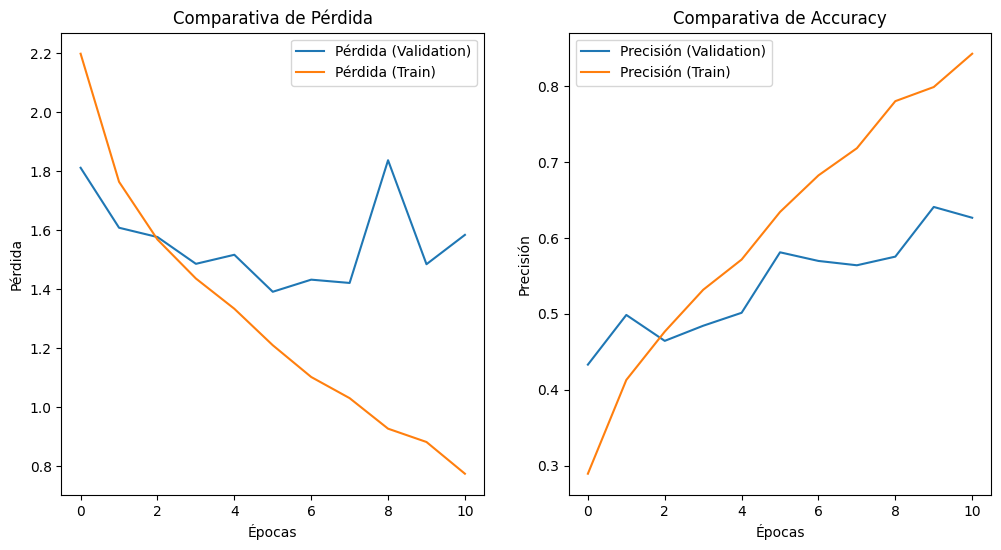

In [124]:
plot_training_history(history_Inceptionv3_conDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 615ms/step - accuracy: 0.5908 - loss: 1.3016
Test Accuracy: 57.67%
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 625ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.66      0.80      0.73        71
           2       0.70      0.40      0.51        70
           3       0.39      0.59      0.47        70
           4       0.46      0.38      0.42        71
           5       0.81      0.71      0.76        70

    accuracy                           0.58       352
   macro avg       0.60      0.58      0.58       352
weighted avg       0.60      0.58      0.58       352


AUC por clase:
Clase 1 (AUC = 0.94106)
Clase 2 (AUC = 0.84828)
Clase 3 (AUC = 0.76613)
Clase 4 (AUC = 0.77603)
Clase 5 (AUC = 0.92194)
AUC Total: 0.85069

Recall por clase:
Clase 1 (Recall = 0.80282)
Clase 2 (Recall = 0.40000)
Clase 3 (Recall = 0.58571)
Clase 4 (Recall = 0.38028)
Clase 5 (Recall = 0.71429)
Recall Total: 0.57662


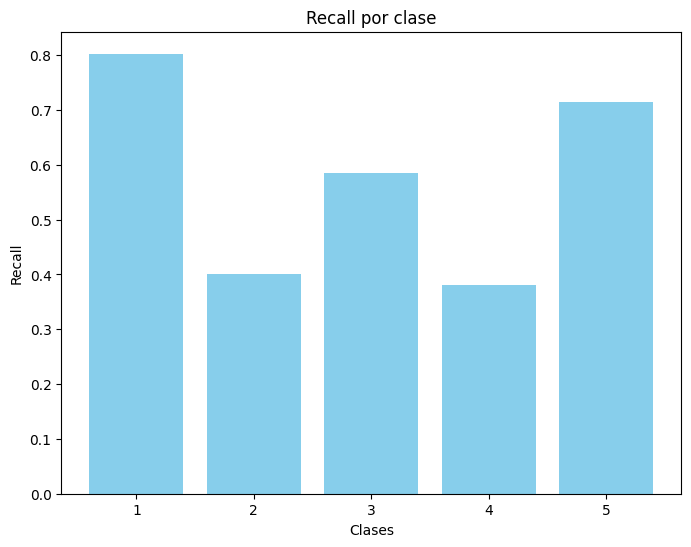

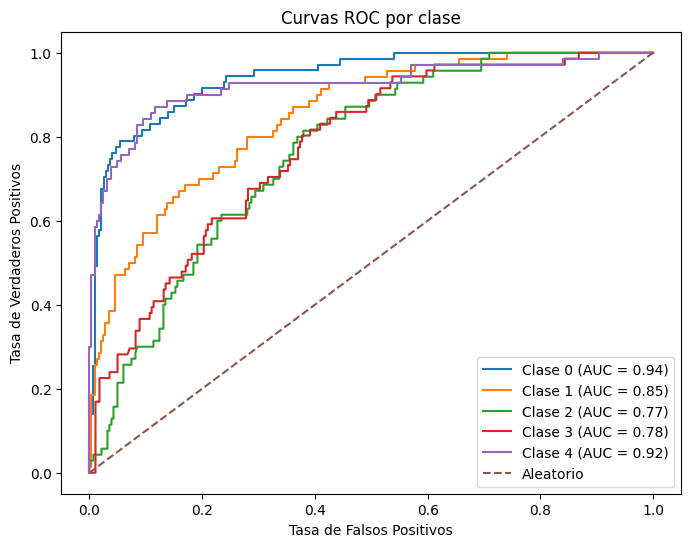

{'AUC': {0: 0.941055586186156,
  1: 0.8482776089159068,
  2: 0.7661347517730496,
  3: 0.7760262643476517,
  4: 0.92193515704154},
 'Recall': array([0.8028169 , 0.4       , 0.58571429, 0.38028169, 0.71428571]),
 'AUC Total': 0.8506858736528609,
 'Recall Total': 0.5766197183098593}

In [125]:
evaluate_model(model_InceptionV3, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [126]:
model_InceptionV3.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_InceptionV3_augm.h5')

**4.2. Sin Data Augmentation**

* Declaración

In [127]:
# Cargar el modelo InceptionV3 preentrenado sin la capa superior (classifier)
base_model_InceptionV3_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [128]:
# Crear el modelo con Transfer Learning y capas personalizadas
model_InceptionV3_2 = create_modelo_with_transferlearning(base_model_InceptionV3_2, num_classes=5, l2value=0.001)

In [129]:
# Resumen del modelo
model_InceptionV3_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_215 (Conv2D)             │ (None, 5, 5, 128)      │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_216 (Conv2D)             │ (None, 5, 5, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_217 (Conv2D)             │ (None, 5, 5, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,357,637 (92.92 MB)

 Trainable params: 2,554,853 (9.75 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

* Entrenamiento

In [130]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_Inceptionv3_sinDataAug = model_InceptionV3_2.fit(
                    X_train_images, y_train_one_hot
                    ,epochs=20
                    ,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - accuracy: 0.2295 - loss: 2.4448 - val_accuracy: 0.3561 - val_loss: 1.9525
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 788ms/step - accuracy: 0.3711 - loss: 1.9010 - val_accuracy: 0.4701 - val_loss: 1.6965
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 783ms/step - accuracy: 0.5081 - loss: 1.6037 - val_accuracy: 0.5071 - val_loss: 1.5369
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 798ms/step - accuracy: 0.5826 - loss: 1.4078 - val_accuracy: 0.5584 - val_loss: 1.4123
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 789ms/step - accuracy: 0.6475 - loss: 1.2145 - val_accuracy: 0.5214 - val_loss: 1.4923
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 780ms/step - accuracy: 0.6891 - loss: 1.1217 - val_accuracy: 0.5328 - val_loss: 1.4722
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 778ms/step - accuracy: 0.7425 - loss: 0.9892 - val_accuracy: 0.6011 - val_loss: 1.5577
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 782ms/step - accuracy: 0.7840 - loss: 0.8625 - val_accu

* Gráfico de Curvas de Pérdida y Precisión

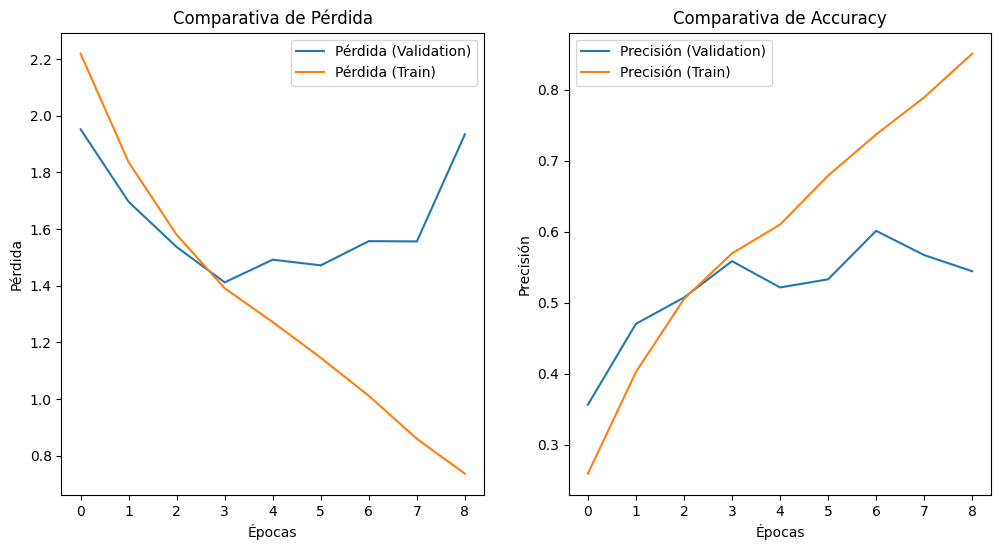

In [131]:
plot_training_history(history_Inceptionv3_sinDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step - accuracy: 0.5845 - loss: 1.3873
Test Accuracy: 56.25%
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 615ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.64      0.76      0.70        71
           2       0.52      0.57      0.54        70
           3       0.37      0.41      0.39        70
           4       0.49      0.31      0.38        71
           5       0.78      0.76      0.77        70

    accuracy                           0.56       352
   macro avg       0.56      0.56      0.56       352
weighted avg       0.56      0.56      0.56       352


AUC por clase:
Clase 1 (AUC = 0.92978)
Clase 2 (AUC = 0.81814)
Clase 3 (AUC = 0.75372)
Clase 4 (AUC = 0.78961)
Clase 5 (AUC = 0.91834)
AUC Total: 0.84192

Recall por clase:
Clase 1 (Recall = 0.76056)
Clase 2 (Recall = 0.57143)
Clase 3 (Recall = 0.41429)
Clase 4 (Recall = 0.30986)
Clase 5 (Recall = 0.75714)
Recall Total: 0.56266


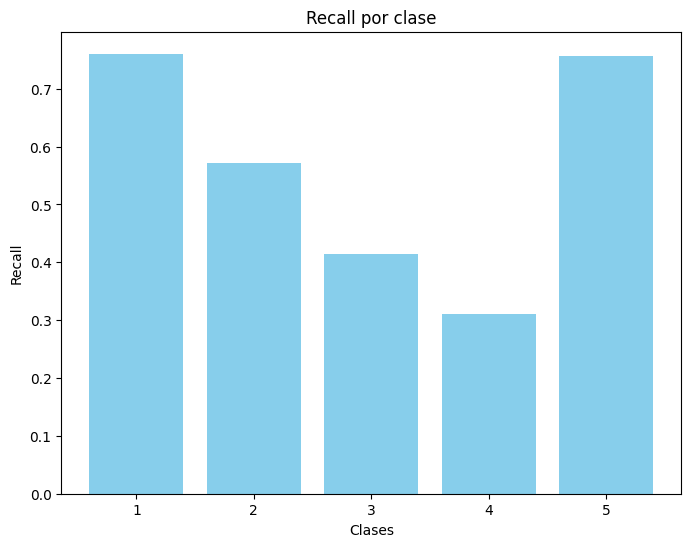

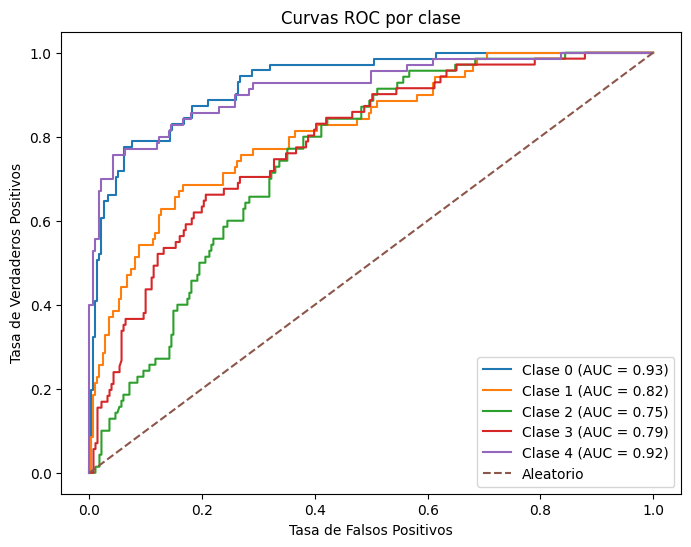

{'AUC': {0: 0.9297779559921808,
  1: 0.8181357649442756,
  2: 0.7537234042553193,
  3: 0.7896095433812842,
  4: 0.9183383991894631},
 'Recall': array([0.76056338, 0.57142857, 0.41428571, 0.30985915, 0.75714286]),
 'AUC Total': 0.8419170135525047,
 'Recall Total': 0.5626559356136821}

In [132]:
evaluate_model(model_InceptionV3_2, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [133]:
model_InceptionV3_2.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_InceptionV3.h5')

**--------------------------------------------------------------------**

**5. MODELO Xception**

**--------------------------------------------------------------------**

Xception es un modelo de Transfer Learning que se basa en la arquitectura de InceptionV3, pero con una optimización adicional mediante el uso de convoluciones separables en profundidad. Este enfoque permite que el modelo sea más eficiente al reducir la cantidad de parámetros, mientras mantiene una alta capacidad de extracción de características complejas de las imágenes

**5.1. Con Data Augmentation**

* Declaración

In [134]:
#cargamos el modelo Xception preentrenado sin la capa superior (classifier)
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [135]:
#creamos el modelo con Transfer Learning y capas personalizadas
model_Xception = create_modelo_with_transferlearning(base_model_Xception, num_classes=5, l2value=0.001)

In [136]:
# Resumen del modelo
model_Xception.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_222 (Conv2D)             │ (None, 7, 7, 128)      │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_223 (Conv2D)             │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_224 (Conv2D)             │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,514,637 (89.70 MB)

 Trainable params: 2,653,157 (10.12 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

* Entrenamiento

In [137]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_Xception_conDataAug = model_Xception.fit(
                    X_train_combined, y_train_combined
                    ,epochs=20
                    #,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.2574 - loss: 2.2025 - val_accuracy: 0.3704 - val_loss: 1.7768
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.3843 - loss: 1.7288 - val_accuracy: 0.4644 - val_loss: 1.5704
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.4713 - loss: 1.5120 - val_accuracy: 0.4558 - val_loss: 1.4820
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.4899 - loss: 1.4115 - val_accuracy: 0.4957 - val_loss: 1.3798
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5518 - loss: 1.2992 - val_accuracy: 0.5271 - val_loss: 1.3721
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5802 - loss: 1.2229 - val_accuracy: 0.4872 - val_loss: 1.4170
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6148 - loss: 1.1505 - val_accuracy: 0.5413 - val_loss: 1.4043
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6683 - loss: 1.0773 - val_accu

* Gráfico de Curvas de Pérdida y Precisión

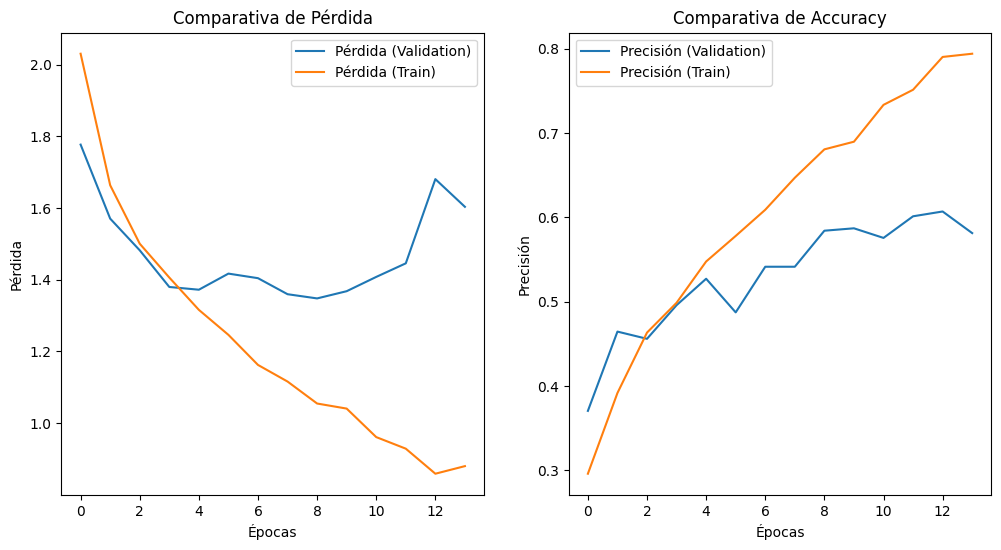

In [138]:
plot_training_history(history_Xception_conDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5549 - loss: 1.4034
Test Accuracy: 57.67%
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.64      0.73      0.68        71
           2       0.53      0.56      0.54        70
           3       0.50      0.46      0.48        70
           4       0.47      0.38      0.42        71
           5       0.71      0.76      0.73        70

    accuracy                           0.58       352
   macro avg       0.57      0.58      0.57       352
weighted avg       0.57      0.58      0.57       352


AUC por clase:
Clase 1 (AUC = 0.90812)
Clase 2 (AUC = 0.85172)
Clase 3 (AUC = 0.77348)
Clase 4 (AUC = 0.77673)
Clase 5 (AUC = 0.92943)
AUC Total: 0.84790

Recall por clase:
Clase 1 (Recall = 0.73239)
Clase 2 (Recall = 0.55714)
Clase 3 (Recall = 0.45714)
Clase 4 (Recall = 0.38028)
Clase 5 (Recall = 0.75714)
Recall Total: 0.57682


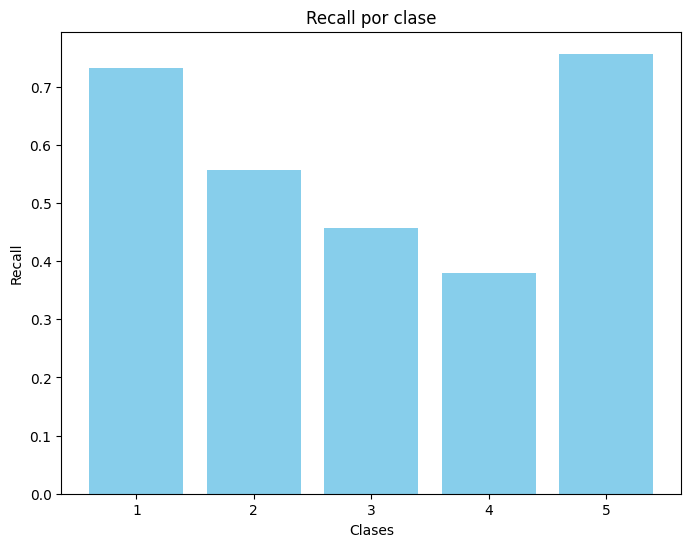

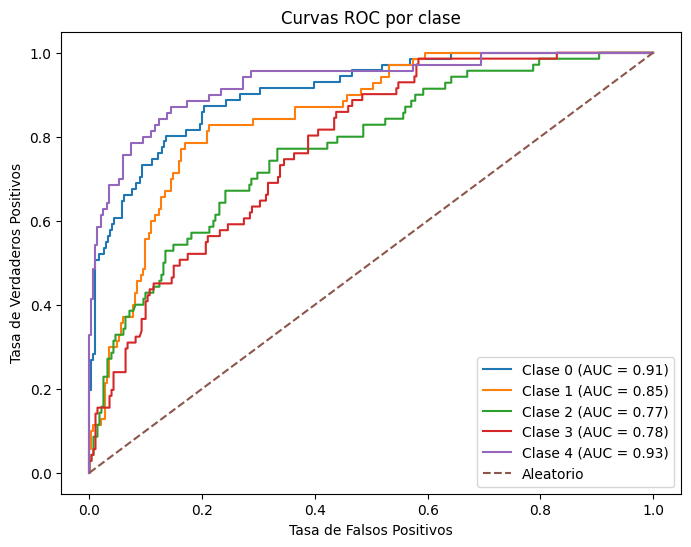

{'AUC': {0: 0.9081249060197484,
  1: 0.8517223910840933,
  2: 0.7734802431610942,
  3: 0.7767279835597214,
  4: 0.9294326241134753},
 'Recall': array([0.73239437, 0.55714286, 0.45714286, 0.38028169, 0.75714286]),
 'AUC Total': 0.8478976295876265,
 'Recall Total': 0.57682092555332}

In [139]:
evaluate_model(model_Xception, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [140]:
model_Xception.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_Xception_augm.h5')

**5.2. Sin Data Augmentation**

* Declaración

In [144]:
# Cargar el modelo Xception preentrenado sin la capa superior (classifier)
base_model_Xception_2 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [145]:
# Crear el modelo con Transfer Learning y capas personalizadas
model_Xception_2 = create_modelo_with_transferlearning(base_model_Xception_2, num_classes=5, l2value=0.001)

In [146]:
# Resumen del modelo
model_Xception_2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_229 (Conv2D)             │ (None, 7, 7, 128)      │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_230 (Conv2D)             │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_231 (Conv2D)             │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,514,637 (89.70 MB)

 Trainable params: 2,653,157 (10.12 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

* Entrenamiento

In [157]:
# Entrenar el modelo con las imágenes originales y aumentadas
history_Xception_sinDataAug = model_Xception_2.fit(
                    X_train_images, y_train_one_hot
                    ,epochs=20
                    ,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.2407 - loss: 2.2888 - val_accuracy: 0.3533 - val_loss: 1.8183
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3834 - loss: 1.7892 - val_accuracy: 0.4330 - val_loss: 1.6160
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4266 - loss: 1.5830 - val_accuracy: 0.4957 - val_loss: 1.4578
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5441 - loss: 1.3149 - val_accuracy: 0.5356 - val_loss: 1.4246
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6052 - loss: 1.2263 - val_accuracy: 0.5328 - val_loss: 1.4213
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6365 - loss: 1.1585 - val_accuracy: 0.5128 - val_loss: 1.5445
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6695 - loss: 1.1306 - val_accuracy: 0.5613 - val_loss: 1.4811
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7317 - loss: 0.9923 - val_accuracy: 0.5328 - v

* Gráfico de Curvas de Pérdida y Precisión

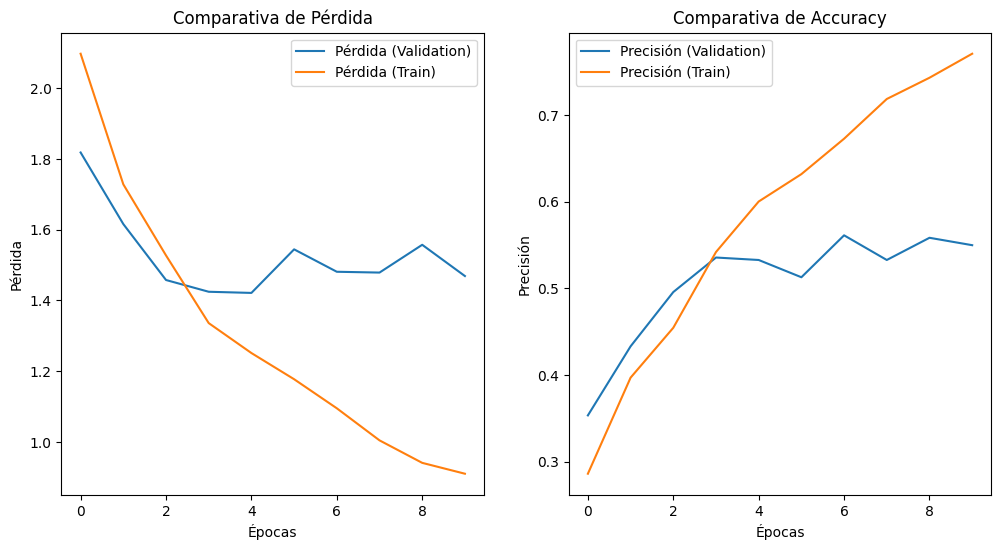

In [158]:
plot_training_history(history_Xception_sinDataAug)

* Evaluación

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5027 - loss: 1.4478
Test Accuracy: 51.42%
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.62      0.56      0.59        71
           2       0.51      0.60      0.55        70
           3       0.38      0.23      0.29        70
           4       0.39      0.39      0.39        71
           5       0.61      0.79      0.69        70

    accuracy                           0.51       352
   macro avg       0.50      0.51      0.50       352
weighted avg       0.50      0.51      0.50       352


AUC por clase:
Clase 1 (AUC = 0.86943)
Clase 2 (AUC = 0.81788)
Clase 3 (AUC = 0.73174)
Clase 4 (AUC = 0.76705)
Clase 5 (AUC = 0.91160)
AUC Total: 0.81954

Recall por clase:
Clase 1 (Recall = 0.56338)
Clase 2 (Recall = 0.60000)
Clase 3 (Recall = 0.22857)
Clase 4 (Recall = 0.39437)
Clase 5 (Recall = 0.78571)
Recall Total: 0.51441


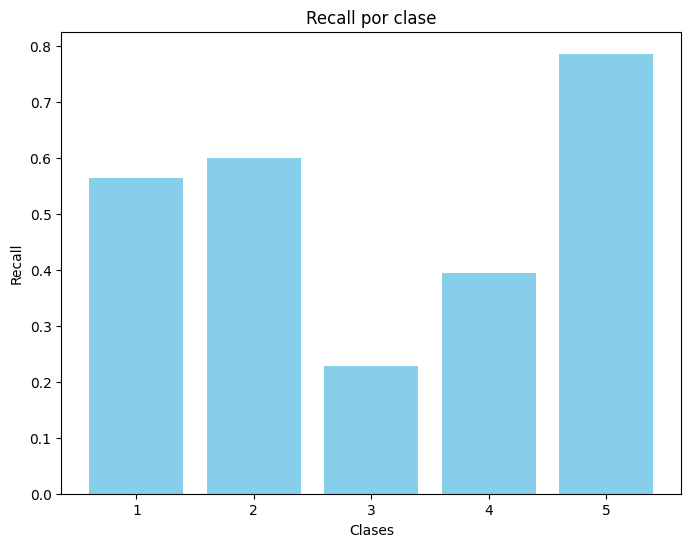

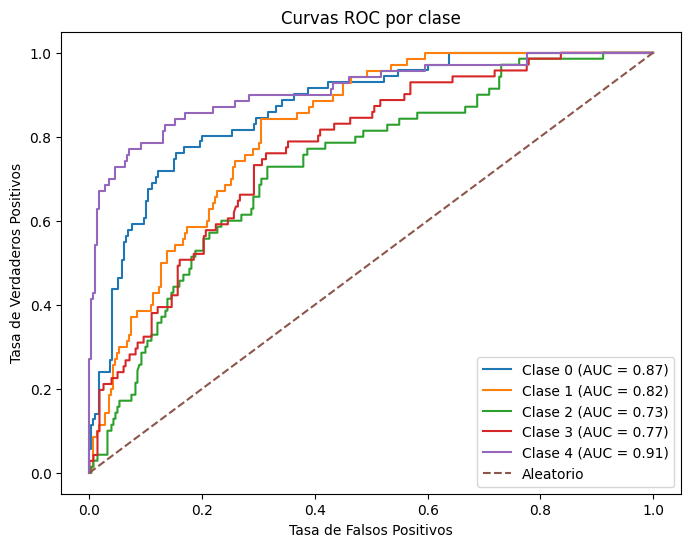

{'AUC': {0: 0.8694301037541977,
  1: 0.8178824721377913,
  2: 0.7317375886524822,
  3: 0.7670542829933336,
  4: 0.9116008105369807},
 'Recall': array([0.56338028, 0.6       , 0.22857143, 0.3943662 , 0.78571429]),
 'AUC Total': 0.8195410516149572,
 'Recall Total': 0.5144064386317908}

In [159]:
evaluate_model(model_Xception_2, X_test_images, y_test_one_hot, num_classes=5)

* Guardamos el modelo

In [160]:
model_Xception_2.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_Xception.h5')

#### **Elección del Modelo**

* **Tabla comparativa**

A continuación, se muestra la tabla comparativa de los valores obtenidos por cada modelo ejecutado, considerando el AUC y RECALL para poder tener una generalización y distinción correcta entre clases.

| Modelo                          | AUC Total | Recall Total | Clase 1 AUC | Clase 2 AUC | Clase 3 AUC | Clase 4 AUC | Clase 5 AUC | Clase 1 Recall | Clase 2 Recall | Clase 3 Recall | Clase 4 Recall | Clase 5 Recall |
|----------------------------------|-----------|--------------|-------------|-------------|-------------|-------------|-------------|----------------|----------------|----------------|----------------|----------------|
| **CNN con Data Augmentation**    | 0.83881   | 0.59082      | 0.85119     | 0.81231     | 0.78994     | 0.81577     | 0.92482     | 0.63380        | 0.51429        | 0.44286        | 0.57746        | 0.78571        |
| **CNN sin Data Augmentation**    | 0.83823   | 0.57972      | 0.82873     | 0.80405     | 0.81335     | 0.81372     | 0.93131     | 0.66197        | 0.45714        | 0.55714        | 0.43662        | 0.78571        |
| **VGG16 con Data Augmentation**  | 0.85784   | 0.55992      | 0.93173     | 0.87285     | 0.77505     | 0.80024     | 0.90932     | 0.73239        | 0.60000        | 0.48571        | 0.29577        | 0.68571        |
| **VGG16 sin Data Augmentation**  | 0.84437   | 0.57042      | 0.90787     | 0.86383     | 0.73609     | 0.81643     | 0.89762     | 0.78873        | 0.60000        | 0.28571        | 0.56338        | 0.61429        |
| **VGG19 con Data Augmentation**  | 0.81522   | 0.53360      | 0.90026     | 0.83688     | 0.68427     | 0.77372     | 0.88095     | 0.74648        | 0.54286        | 0.17143        | 0.49296        | 0.71429        |
| **VGG19 sin Data Augmentation**  | 0.85032   | 0.59062      | 0.92030     | 0.86028     | 0.72586     | 0.82685     | 0.91829     | 0.80282        | 0.55714        | 0.42857        | 0.47887        | 0.68571        |
| **InceptionV3 con Data Augmentation** | 0.85069   | 0.57662      | 0.94106     | 0.84828     | 0.76613     | 0.77603     | 0.92194     | 0.80282        | 0.40000        | 0.58571        | 0.38028        | 0.71429        |
| **InceptionV3 sin Data Augmentation** | 0.84192   | 0.56266      | 0.92978     | 0.81814     | 0.75372     | 0.78961     | 0.91834     | 0.76056        | 0.57143        | 0.41429        | 0.30986        | 0.75714        |
| **Xception con Data Augmentation** | 0.84790   | 0.57682      | 0.90812     | 0.85172     | 0.77348     | 0.77673     | 0.92943     | 0.73239        | 0.55714        | 0.45714        | 0.38028        | 0.75714        |
| **Xception sin Data Augmentation** | 0.81954   | 0.51441      | 0.86943     | 0.81788     | 0.73174     | 0.76705     | 0.91160     | 0.56338        | 0.60000        | 0.22857        | 0.39437        | 0.78571        |

* **Decisión de Elección**

Con base en el enfoque buscado, es decir, priorizando **AUC** (para capacidad de discriminación entre clases) y sobretodo **recall** (para asegurar que el modelo no se pierda ninguna clase importante), se ha seleccionado tanto el modelo **InceptionV3 con Data Augmentation** como el **VGG19 sin Data Augmentation**. Ambos modelos muestran un buen equilibrio entre estos dos indicadores clave, lo que los hace adecuados para la clasificación TI-RADS, un problema en el que la capacidad de discriminar entre clases y la correcta identificación de cada clase es crucial.

**a. AUC Total:**

- InceptionV3 con Data Augmentation** tiene un AUC total de 0.85069, lo que le otorga una excelente capacidad de discriminación entre clases.
- VGG19 sin Data Augmentation** también tiene un AUC total de 0.85032, muy cercano al de InceptionV3, demostrando también una gran capacidad para distinguir entre las clases.


**b. Recall Total:**
 

- InceptionV3 con Data Augmentation tiene un recall total de 0.57662, lo que es bastante bueno y nos muestra una capacidad aceptable para identificar correctamente las clases; sin embargo, presenta un recall bajo en la Clase 2 (0.40) y Clase 4 (0.38028).
- VGG19 sin Data Augmentation, con un recall total de 0.59062, también muestra un buen desempeño, destacando en Clase 1 (0.802) y Clase 5 (0.68571), aunque presenta un recall bajo en Clase 3 (0.42857) y Clase 4 (0.47887).

  
**c. Equilibrio en las Clases:**

Ambos modelos presentan un patrón en el que, aunque el recall de algunas clases es bajo, mantienen un buen rendimiento en las clases más críticas, como Clase 1 y Clase 5, lo que sugiere que los modelos tienen la capacidad de identificar las clases relevantes sin sesgarse demasiado hacia alguna clase en particular.


**d. Comparación con otros modelos:**

Ambos modelos presentan características destacables en su rendimiento:

- InceptionV3 con Data Augmentation se destaca por su AUC más alto (0.85069), lo que indica una excelente capacidad de discriminación entre clases. Aunque tiene un recall bajo en algunas clases, su alto recall en clases críticas, como la Clase 1 (0.802) y Clase 5 (0.71429), hace que este modelo sea robusto en cuanto a su capacidad para identificar las clases más importantes.

- VGG19 sin Data Augmentation, aunque con un AUC cercano (0.85032), tiene un recall global ligeramente más alto (0.59062) debido a su mejor desempeño en Clase 1 (0.802). Sin embargo, su recall en la clases 3 es más bajo que el de InceptionV3, y el de la Clase 4 también es relativamente bajo, lo que podría indicar que, al igual que InceptionV3, tendría dificultades con las clases menos representadas o más difíciles de identificar.

### **C. Optimización del Modelo**

En esta fase, se realizará una optimización del modelo utilizando la técnica de fine-tuning sobre el modelo preentrenado de **InceptionV3 con Data Augmentation** y el de **VGG19 sin Data Augmentation**. A diferencia de la optimización de hiperparámetros tradicional, como GridSearchCV, el **fine-tuning** se enfoca en mejorar el rendimiento del modelo ajustando las últimas capas de un modelo preentrenado.

El objetivo principal de este proceso es adaptar el modelo, que ya tiene un buen rendimiento gracias a su entrenamiento previo en ImageNet, a las características específicas de nuestro conjunto de datos sobre TI-RADS.

 #### **Proceso de Fine-Tuning:**

**1. Congelación de capas:** Primero, congelaremos las primeras capas del modelo base. Estas capas ya han aprendido características generales sobre imágenes durante su entrenamiento en ImageNet. Al congelarlas, evitamos que se modifiquen durante el proceso de entrenamiento y permitimos que el modelo se enfoque en ajustar las últimas capas para que se adapten mejor a nuestro conjunto de datos específico.

**2. Descongelar las capas superiores:** Después, descongelamos algunas de las últimas capas del modelo base para permitir que se ajusten a las características de nuestro conjunto de datos. Esto nos permitirá aprovechar la capacidad del modelo preentrenado para aprender patrones más específicos, sin perder los conocimientos generales que ya tiene.

**3. Ajuste de la arquitectura del modelo:** Se añade una capa densa de 128 neuronas y una capa Dropout para evitar el sobreajuste. Esta capa de Dropout es crucial para regularizar el modelo y asegurar que no se memoricen patrones irrelevantes.

**4. Compilación y entrenamiento:** Finalmente, el modelo se recompila con un learning rate más bajo para realizar el ajuste fino sin desestabilizar los pesos previamente entrenados. Se utiliza el optimizador Adam, y el modelo se entrena sobre el conjunto de datos con un número reducido de épocas, permitiendo que el ajuste fino sea progresivo.

El fine-tuning no solo mejora la capacidad del modelo para generalizar sobre nuevas imágenes, sino que también optimiza su capacidad de clasificación en nuestro conjunto de datos de TI-RADS.

 #### **Mejoras del Modelo:**

* **Regularización mediante Dropout:** Durante el fine-tuning, utilizamos la técnica de Dropout para evitar el sobreajuste. El Dropout actúa desconectando aleatoriamente ciertas neuronas durante el entrenamiento, lo que obliga al modelo a aprender representaciones más robustas y generalizables.

* **Optimización de la Arquitectura:** Utilizamos las arquitecturas nativas de los modelos entrenados como modelos bases y ajustaremos sus últimas capas para que se adapten a la tarea específica de clasificación de TI-RADS. A través del fine-tuning, aprovechamos las capacidades de este modelo preentrenado y lo ajustamos para obtener un mejor rendimiento en nuestro conjunto de datos.

#### **Evaluación del Modelo Optimizado:**

Después de realizar el fine-tuning, el modelo optimizado se evaluará utilizando la métrica de AUC (Área Bajo la Curva ROC). Dado que el objetivo es maximizar la capacidad del modelo para discriminar entre las diferentes clases, AUC será la métrica principal de evaluación. Un AUC alto indica que el modelo está bien entrenado y tiene una excelente capacidad para diferenciar entre las clases.

Aunque el recall por clase también puede ser relevante en algunos casos, AUC será nuestra métrica clave para evaluar la capacidad del modelo para generalizar sobre nuevas imágenes y discriminar efectivamente entre las clases de TI-RADS.

#### **Implementación:**

**1. FINE TUNNING - InceptionV3 con Data Augmentation**

- Descongelamos algunas capas finales de la base para ajuste fino

In [80]:
model_path_inception = r"D:\Academico\Master Inteligencia Artificial - UAX - 2024_2025\Asignaturas\0. TFM\final\model\lastversion\tirads_model_InceptionV3_augm.h5"
model_InceptionV3_pretunning = load_model(model_path_inception)

In [81]:
#Accedemos a la base del modelo preentrenado con mejores resultados "Inception V3 con Data Augmentation"
base_model_inception_finetuned = model_InceptionV3_pretunning.layers[0]  # Acceder a la base preentrenada
base_model_inception_finetuned.trainable = True

* Congelamos todas las capas menos las últimas 50

In [5]:
for layer in base_model_inception_finetuned.layers[:-50]:
    layer.trainable = False

* Creamos el modelo final con las capas personalizadas

In [6]:
model_inceptionAug_finetuned = Sequential()
#usamos la base preentrenada InceptionV3
model_inceptionAug_finetuned.add(base_model_inception_finetuned) 
# Aplanamos la salida de las capas convolucionales
model_inceptionAug_finetuned.add(Flatten())  
 # Capa densa
model_inceptionAug_finetuned.add(Dense(128, activation='relu')) 
# Regularización con Dropout
model_inceptionAug_finetuned.add(Dropout(0.5))  
# Capa de salida con 5 clases para TI-RADS
model_inceptionAug_finetuned.add(Dense(5, activation='softmax'))  

* Compilamos el modelo con un learning rate más bajo para fine-tuning

In [7]:
model_inceptionAug_finetuned.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

* Summary

In [8]:
model_inceptionAug_finetuned.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,357,157 (108.17 MB)

 Trainable params: 13,727,685 (52.37 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

* Entrenamos el modelo con fine-tuning

In [75]:
history_InceptionV3conDataAug_finetuned = model_inceptionAug_finetuned.fit(
    X_train_combined, 
    y_train_combined,
    validation_data=(X_val_images, y_val_one_hot),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 134s 862ms/step - accuracy: 0.2398 - loss: 1.7844 - val_accuracy: 0.3789 - val_loss: 1.4568
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 856ms/step - accuracy: 0.4113 - loss: 1.3961 - val_accuracy: 0.5043 - val_loss: 1.2805
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 854ms/step - accuracy: 0.5556 - loss: 1.1577 - val_accuracy: 0.5499 - val_loss: 1.1586
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 866ms/step - accuracy: 0.6407 - loss: 0.9672 - val_accuracy: 0.5698 - val_loss: 1.0894
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 123s 936ms/step - accuracy: 0.7097 - loss: 0.7935 - val_accuracy: 0.6125 - val_loss: 1.0307
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 917ms/step - accuracy: 0.7768 - loss: 0.6598 - val_accuracy: 0.6068 - val_loss: 1.0036
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 886ms/step - accuracy: 0.8325 - loss: 0.5291 - val_accuracy: 0.6524 - val_loss: 0.9580
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 858ms/step - accuracy: 0.8801 -

* Gráfico de Curvas de Pérdida y Precisión

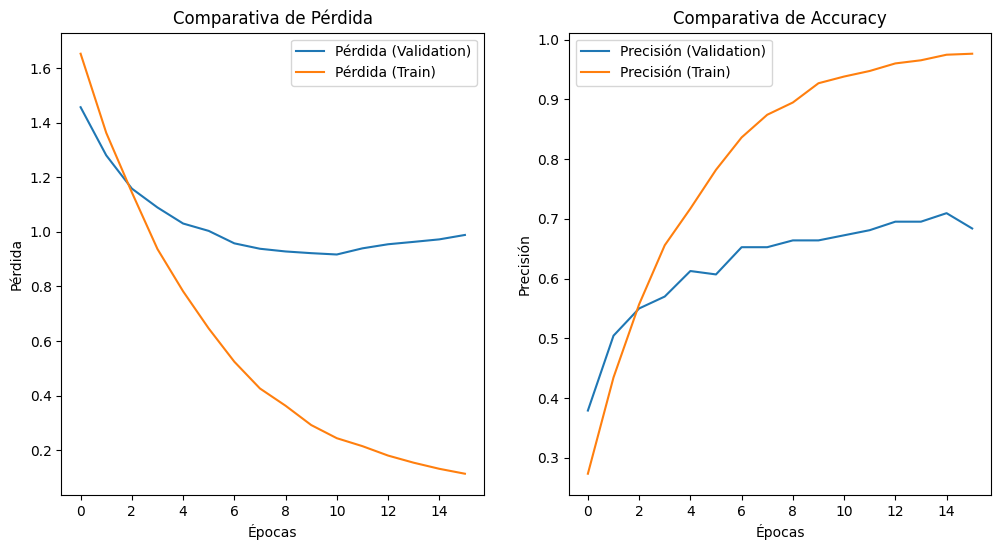

In [76]:
plot_training_history(history_InceptionV3conDataAug_finetuned)

* Evaluamos

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 656ms/step - accuracy: 0.6689 - loss: 0.9180
Test Accuracy: 67.33%
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 613ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.82      0.76      0.79        71
           2       0.71      0.63      0.67        70
           3       0.61      0.61      0.61        70
           4       0.49      0.58      0.53        71
           5       0.79      0.79      0.79        70

    accuracy                           0.67       352
   macro avg       0.68      0.67      0.68       352
weighted avg       0.68      0.67      0.68       352


AUC por clase:
Clase 1 (AUC = 0.94827)
Clase 2 (AUC = 0.88723)
Clase 3 (AUC = 0.87064)
Clase 4 (AUC = 0.85442)
Clase 5 (AUC = 0.93784)
AUC Total: 0.89968

Recall por clase:
Clase 1 (Recall = 0.76056)
Clase 2 (Recall = 0.62857)
Clase 3 (Recall = 0.61429)
Clase 4 (Recall = 0.57746)
Clase 5 (Recall = 0.78571)
Recall Total: 0.67332


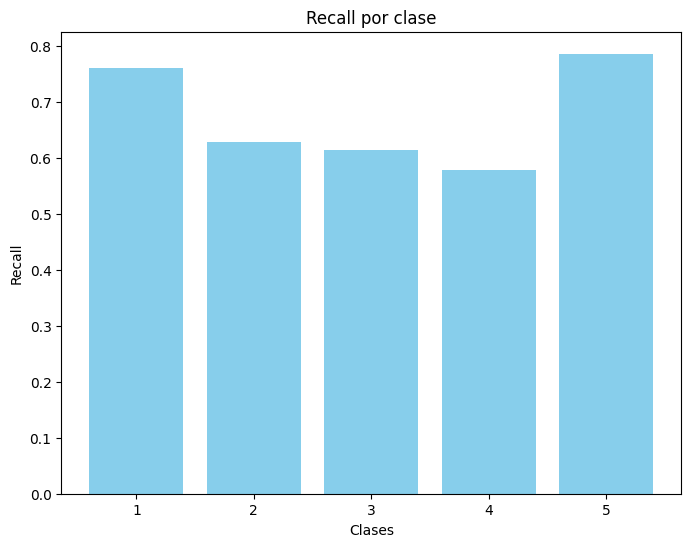

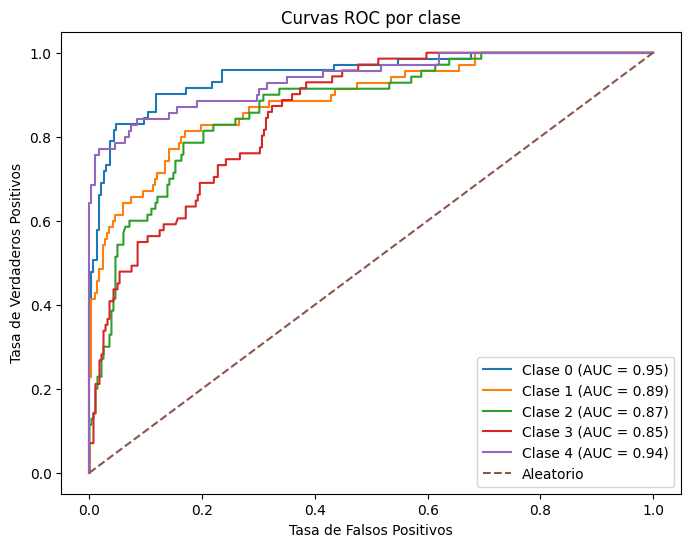

{'AUC': {0: 0.9482732695103002,
  1: 0.8872340425531915,
  2: 0.8706433637284702,
  3: 0.8544183248959951,
  4: 0.9378419452887538},
 'Recall': array([0.76056338, 0.62857143, 0.61428571, 0.57746479, 0.78571429]),
 'AUC Total': 0.8996821891953422,
 'Recall Total': 0.6733199195171026}

In [77]:
evaluate_model(model_inceptionAug_finetuned, X_test_images, y_test_one_hot, num_classes=5)

In [78]:
model_inceptionAug_finetuned.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_InceptionV3_augm_FineTuning.h5')

In [79]:
model_inceptionAug_finetuned.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_InceptionV3_augm_FineTuning.keras')

**2. FINE TUNNING - VGG19 sin Data Augmentation**

- Descongelamos algunas capas finales de la base para ajuste fino

In [82]:
model_path_vgg19 = r"D:\Academico\Master Inteligencia Artificial - UAX - 2024_2025\Asignaturas\0. TFM\final\model\lastversion\tirads_model_VGG19.h5"
model_VGG19_pretunning = load_model(model_path_vgg19)

In [83]:
#Accedemos a la base del modelo preentrenado con mejores resultados "VGG19 sin Data Augmentation"
base_model_vgg19_finetuned = model_VGG19_pretunning.layers[0]  # Acceder a la base preentrenada
base_model_vgg19_finetuned.trainable = True

* Congelamos todas las capas menos las últimas 50

In [85]:
for layer2 in base_model_vgg19_finetuned.layers[:-50]:
    layer2.trainable = False

* Creamos el modelo final con las capas personalizadas

In [86]:
model_vgg19_finetuned = Sequential()
#usamos la base preentrenada VGG19
model_vgg19_finetuned.add(base_model_vgg19_finetuned) 
# Aplanamos la salida de las capas convolucionales
model_vgg19_finetuned.add(Flatten())  
 # Capa densa
model_vgg19_finetuned.add(Dense(128, activation='relu')) 
# Regularización con Dropout
model_vgg19_finetuned.add(Dropout(0.5))  
# Capa de salida con 5 clases para TI-RADS
model_vgg19_finetuned.add(Dense(5, activation='softmax'))  

* Compilamos el modelo con un learning rate más bajo para fine-tuning

In [87]:
model_vgg19_finetuned.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

* Resumen del modelo

In [88]:
model_vgg19_finetuned.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,236,421 (88.64 MB)

 Trainable params: 23,236,421 (88.64 MB)

 Non-trainable params: 0 (0.00 B)

* Entrenamos el modelo con el conjunto de datos

In [89]:
history_VGG19sinDataAug_finetuned= model_vgg19_finetuned.fit(
                    X_train_images, y_train_one_hot
                    ,epochs=20
                    ,batch_size=32
                    ,validation_data=(X_val_images, y_val_one_hot)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1325s 15s/step - accuracy: 0.2287 - loss: 1.7378 - val_accuracy: 0.3761 - val_loss: 1.3939
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1326s 15s/step - accuracy: 0.3856 - loss: 1.3997 - val_accuracy: 0.4217 - val_loss: 1.2788
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1316s 15s/step - accuracy: 0.4530 - loss: 1.2648 - val_accuracy: 0.4900 - val_loss: 1.2190
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1313s 15s/step - accuracy: 0.5414 - loss: 1.1462 - val_accuracy: 0.5470 - val_loss: 1.1121
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1308s 15s/step - accuracy: 0.5575 - loss: 1.0777 - val_accuracy: 0.6011 - val_loss: 1.0263
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1307s 15s/step - accuracy: 0.6812 - loss: 0.8624 - val_accuracy: 0.5755 - val_loss: 0.9805
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1311s 15s/step - accuracy: 0.6889 - loss: 0.7851 - val_accuracy: 0.6296 - val_loss: 0.8947
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1327s 15s/step - accuracy: 0.7346 - loss: 0.6809 - val_accu

* Graficamos la historia de entrenamiento

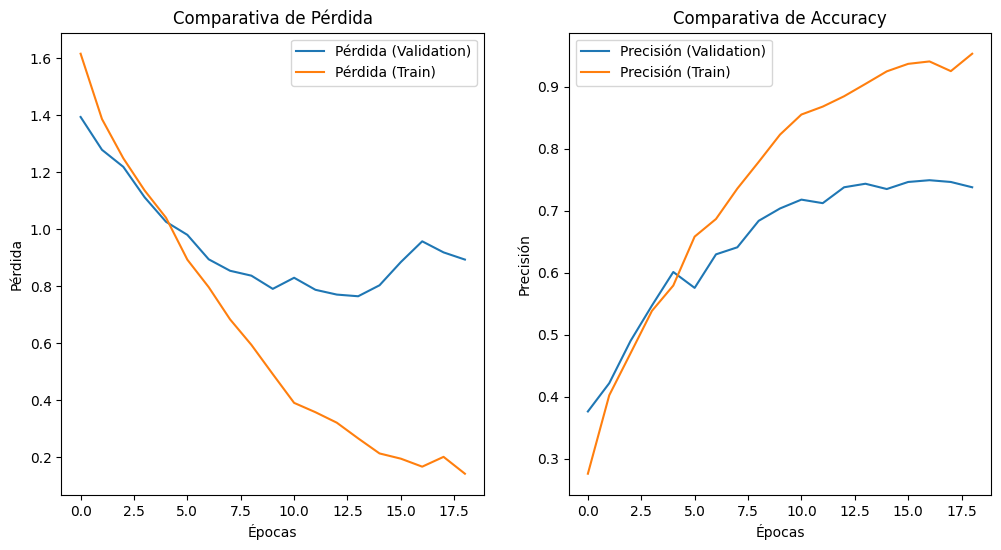

In [90]:
plot_training_history(history_VGG19sinDataAug_finetuned)

* Evaluamos el modelo optimizado

11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7081 - loss: 0.9480
Test Accuracy: 72.73%
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.82      0.79      0.81        71
           2       0.74      0.76      0.75        70
           3       0.64      0.69      0.66        70
           4       0.69      0.54      0.60        71
           5       0.74      0.87      0.80        70

    accuracy                           0.73       352
   macro avg       0.73      0.73      0.72       352
weighted avg       0.73      0.73      0.72       352


AUC por clase:
Clase 1 (AUC = 0.94431)
Clase 2 (AUC = 0.93029)
Clase 3 (AUC = 0.88402)
Clase 4 (AUC = 0.86179)
Clase 5 (AUC = 0.95304)
AUC Total: 0.91469

Recall por clase:
Clase 1 (Recall = 0.78873)
Clase 2 (Recall = 0.75714)
Clase 3 (Recall = 0.68571)
Clase 4 (Recall = 0.53521)
Clase 5 (Recall = 0.87143)
Recall Total: 0.72765


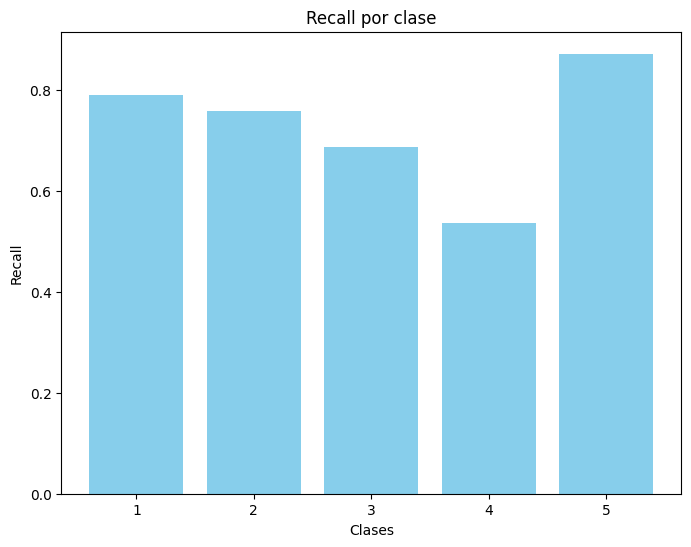

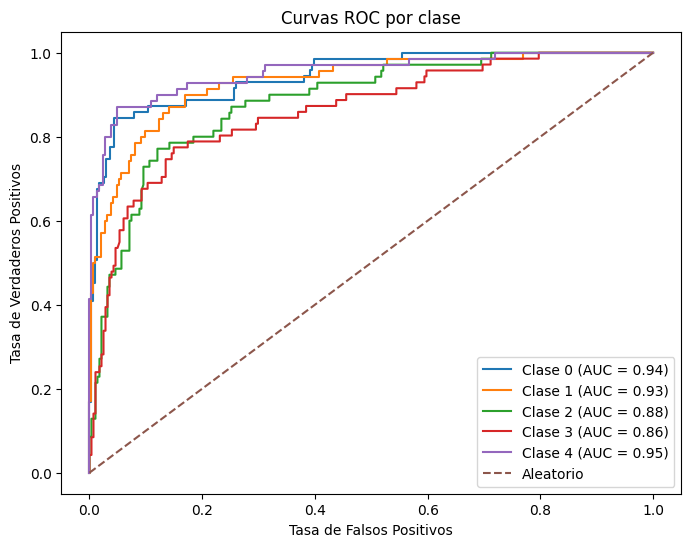

{'AUC': {0: 0.9443135682421934,
  1: 0.9302938196555217,
  2: 0.8840172239108409,
  3: 0.8617863766227256,
  4: 0.9530395136778116},
 'Recall': array([0.78873239, 0.75714286, 0.68571429, 0.53521127, 0.87142857]),
 'AUC Total': 0.9146901004218186,
 'Recall Total': 0.7276458752515091}

In [91]:
evaluate_model(model_vgg19_finetuned, X_test_images, y_test_one_hot, num_classes=5)

In [92]:
model_vgg19_finetuned.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_VGG19_FineTuning.h5')

In [93]:
model_vgg19_finetuned.save('D:/Academico/Master Inteligencia Artificial - UAX - 2024_2025/Asignaturas/0. TFM/final/model/lastversion/tirads_model_VGG19_FineTuning.keras')

# **VI. Revisión y Análisis de Resultados**

#### **Análisis de Resultados**

Al comparar los resultados obtenidos de los modelos **InceptionV3 con Data Augmentation + Fine-Tuning** y **VGG19 sin Data Augmentation + Fine-Tuning**, se observa que ambos modelos tienen un buen desempeño, pero presentan algunas diferencias clave en términos de AUC y Recall, que serián cruciales para la clasificación precisa en el contexto de TIRADS.

#### **Comparación de Resultados**

| Modelo                               | **AUC Total** | **Recall Total** | **Clase 1 AUC** | **Clase 2 AUC** | **Clase 3 AUC** | **Clase 4 AUC** | **Clase 5 AUC** | **Clase 1 Recall** | **Clase 2 Recall** | **Clase 3 Recall** | **Clase 4 Recall** | **Clase 5 Recall** |
|--------------------------------------|---------------|------------------|-----------------|-----------------|-----------------|-----------------|-----------------|--------------------|--------------------|--------------------|--------------------|--------------------|
| **VGG19 sin Data Augmentation + Fine Tuning**     | **0.91469**   | **0.72765**      | **0.94431**     | **0.93029**     | **0.88402**     | **0.86179**     | **0.95304**     | **0.78873**        | **0.75714**        | **0.68571**        | **0.53521**        | **0.87143**        |
| **InceptionV3 con Data Augmentation + Fine Tuning** | **0.89968**   | **0.67332**      | **0.94827**     | **0.88723**     | **0.87064**     | **0.85442**     | **0.93784**     | **0.76056**        | **0.62857**        | **0.61429**        | **0.57746**        | **0.78571**        |

* **AUC Total:**

    * VGG19 sin Data Augmentation + Fine-Tuning: 0.91469
    * InceptionV3 con Data Augmentation + Fine-Tuning: 0.89968

**Interpretación:** El modelo VGG19 sin Data Augmentation muestra un AUC total más alto, lo que sugeriría que tiene una mayor capacidad para discriminar entre las clases en general. Esto es especialmente importante porque un AUC más alto indica que el modelo tiene un mejor desempeño en la clasificación general de las clases, capturando con mayor precisión las diferencias entre las categorías TIRADS.
 
* **Recall Total:**

    * VGG19 sin Data Augmentation + Fine-Tuning: 0.72765
    * InceptionV3 con Data Augmentation + Fine-Tuning: 0.67332

**Interpretación:** El modelo VGG19 sin Data Augmentation muestra un recall total más alto de 0.72765, lo que significa que tiene una mayor capacidad para identificar correctamente las instancias de cada clase, particularmente en las clases menos representadas o más difíciles de identificar.

#### **Análisis de Clases Específicas**

* **Clase 1 (TIRADS 1):**
  
    - VGG19 sin Data Augmentation + Fine-Tuning: **Recall** = 0.78873, **AUC** = 0.94431
    - InceptionV3 con Data Augmentation + Fine-Tuning: **Recall** = 0.76056, **AUC** = 0.94827
    - Ambos modelos tienen un buen desempeño en la Clase 1, con VGG19 sin Data Augmentation mostrando un recall ligeramente superior, lo que indica que este modelo es un poco mejor en identificar correctamente los nódulos de bajo riesgo. Además, el AUC alto en ambas configuraciones sugiere que ambos modelos son bastante buenos en discriminar entre nódulos TI-RADS 1 y las otras clases.



* **Clase 4 (TIRADS 4):**
  
    - VGG19 sin Data Augmentation + Fine-Tuning: **Recall** = 0.53521, **AUC** = 0.86179
    - InceptionV3 con Data Augmentation + Fine-Tuning: **Recall** = 0.57746, **AUC** = 0.85442
    - La Clase 4 muestra un bajo recall en ambos modelos, pero el InceptionV3 con Data Augmentation tiene un recall ligeramente superior en esta clase, lo que indica que InceptionV3 está capturando más instancias correctas de los nódulos de riesgo intermedio. Sin embargo, el AUC de VGG19 sin Data Augmentation es ligeramente superior, lo que muestra que VGG19 tiene una mejor capacidad para discriminar entre las clases, aunque no está identificando bien todas las instancias de la Clase 4.


* **Clase 5 (TIRADS 5):**
  
    - VGG19 sin Data Augmentation + Fine-Tuning: **Recall** = 0.87143, **AUC** = 0.95304
    - InceptionV3 con Data Augmentation + Fine-Tuning: **Recall** = 0.78571, **AUC** =  0.93784
    - La Clase 5, que es crítica para la detección de nódulos malignos, muestra un mejor recall en VGG19 sin Data Augmentation, lo que es crucial ya que no queremos perder instancias de alto riesgo. Además, el AUC superior de VGG19 sin Data Augmentation indica que este modelo tiene una mayor capacidad para discriminar correctamente los nódulos malignos de los no malignos.


#### **Recomendaciones de Revisión de Resultados**

**1. Ajustes en los Datos:**

VGG19 sin Data Augmentation ha demostrado un mejor rendimiento en términos de recall en las clases clave, como Clase 5, pero sigue siendo importante considerar más datos de entrenamiento para mejorar el recall en clases más difíciles como la Clase 4. Se recomendaría aumentar la cantidad de imágenes en estas clases podría ayudar a mejorar la capacidad de generalización del modelo y seguir fortaleciéndolo.

**2. Ajuste en la Arquitectura:**

Si bien VGG19 sin Data Augmentation ha mostrado buenos resultados en cuanto a AUC y Recall, sería interesante experimentar con otras arquitecturas preentrenadas, como ResNet o EfficientNet, para verificar si podemos obtener un rendimiento aún mejor con fine-tuning en estos modelos.

**3.Aumento de Datos:**

Aunque Data Augmentation ha mostrado buenos resultados en InceptionV3, podría ser útil probar diferentes estrategias de augmentación para mejorar aún más el rendimiento del modelo. Ajustar las transformaciones, como rotaciones más extremas, desplazamientos, y escalado, podría ayudar a mejorar la capacidad de generalización, especialmente en clases difíciles.

**4.Ajuste de Parámetros de Fine-Tuning:**

Sería útil experimentar con más capas congeladas o tasa de aprendizaje para ver si podemos mejorar el recall en las clases con bajo rendimiento, como la Clase 4. Además, probar con learning rate schedules podría ser útil para mejorar la estabilidad y el rendimiento del modelo.

#### **Conclusión**

**Resultado Final:** Tras realizar el análisis comparativo, ambos modelos (InceptionV3 con Data Augmentation + Fine-Tuning y VGG19 sin Data Augmentation + Fine-Tuning) muestran buenos resultados, pero **VGG19 sin Data Augmentation** se destaca por su mejor recall total y su AUC ligeramente superior en comparación con InceptionV3 con Data Augmentation. Sin embargo, la diferencia en AUC entre ambos modelos es mínima, por lo que la decisión final depende de la prioridad que se le dé al recall en clases específicas (como Clase 5). En este caso, **VGG19 sin Data Augmentation muestra un recall más alto en la Clase 5, lo que hace que sea más adecuado para este escenario, donde la correcta clasificación de nódulos malignos es crítica.**

--==================================================================================

--==================================================================================

--==================================================================================

--==================================================================================

**EJEMPLO DE USO**

In [94]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

In [128]:
def prediccion_tirads_imagenes(model_path, img_path, file_test_name, target_size=(224, 224)):
    # Cargamos el modelo
    model_load_sample = load_model(model_path)

    #obtenemos el path completo de la imagen
    img_full_path = os.path.join(img_path, file_test_name)

    #cargamos y preparamos la imagen
    imgload = image.load_img(img_full_path, target_size=target_size)
    img_array_sample = image.img_to_array(imgload)
    img_array_sample = img_array_sample / 255.0  #normalizamos
    img_array_sample = np.expand_dims(img_array_sample, axis=0)  # Añadimos una dimensión extra para el batch

    #Predecimos con el modelo cargado
    pred_load_samples = model_load_sample.predict(img_array_sample)
    pred_class_load_samples = np.argmax(pred_load_samples, axis=1)

    #Resultados
    print("Probabilidades:", pred_load_samples)
    print("Clase predicha TI-RADS:", pred_class_load_samples[0] + 1)

    return pred_class_load_samples[0] + 1, pred_load_samples

In [139]:
#Especificamos la ruta del path del modelo
model_path = r"D:\Academico\Master Inteligencia Artificial - UAX - 2024_2025\Asignaturas\0. TFM\final\model\lastversion\tirads_model_VGG19_FineTuning.h5"

In [140]:
#Asignamos la ruta y nombre de la imagen
img_path = r"D:\Academico\Master Inteligencia Artificial - UAX - 2024_2025\Asignaturas\0. TFM\final\model\Pruebas_load"
file_test_name = "4_1_tiroides186.jpg"  #cambiar

In [141]:
#Obtenemos la clase de predicción tirads
prediccion_tirads_imagenes(model_path, img_path, file_test_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Probabilidades: [[0.00319063 0.02592346 0.00206509 0.95949614 0.00932468]]
Clase predicha TI-RADS: 4


(4,
 array([[0.00319063, 0.02592346, 0.00206509, 0.95949614, 0.00932468]],
       dtype=float32))